#### Experiments to demonstrate that weights evolve via D4 when given noise without signal.

The weights of a neural network will shift according to D4(x) := d^x/dx^2 (s(x)*(d/dt s(x))) * when the network computes activations using sigmoidal nonlinear function s(x) such as tanh. This is a result of combination of weights that experience a noisy error signal and the curvature of D2 (see signal-follows-D2). To support this claim, this notebook runs a tiny experiment that compares analytic predictions of the theory with observed reality.

To simplify the analysis without a loss of generality, we substitute changing weights with changing weights-divided-by-x-value, dubbed v or v_i. 
We calculate the gradient signal received by a vi, i.e. the gradient signal received by 'weight mod x_j input', which only vertically scales our results and thus isn't important to our questions of whether weights follow D2 or not. A tensorflow network is run under different sources of noise, such as data-driven noise, discretized algorithm noise, or broken symmetry of weights noise (see info.txt for more details), run in both minimally-simple cases and in more realistic cases.
Changes in weights are collected into a graph do determine if the analytic prediction (noise follows D4) matches up with the observed reality (how does a weight mod x change under noisy backprop).

#### Results:
\* Based on even just the simple cases data={(x,y),(x,-y)}, it seems my analysis was a little off. Instead of expected D4(x) = d^2/dx^2 D2(x), it seems that D4(x) = D2(x) * d/dx D2(x). Empirically, the numbers add up. D4(x) and D2(x) thus have the same functional relationship that D2(x) and s(x) have. These new D4 have the same basic shape that original D4 had, but it plays nicer with other functions too. Interesting.

New points to note, now:
- for all sigmoidals, beta == gamma, meaning the point where signal rules is precisely where noise recedes. Alpha is drawn closer to 0, the peak at alpha tends to be much larger while the peak at delta gets *much* smaller
- for x/(1+|x|)==softsign and exp* == {odd extension of 1-e^-x,x>0}, delta/beta == beta/alpha. 
    softsign ratio: 0.3873; exp* ratio: 0.495.
- softsign alpha/beta-gamma/delta: l=[1.0083, .6585, 0.2934].
- tanh a/bg/d: l=[1.0083, .6585, 0.2934]
- erf: [.9388, .6201, .2879]
- exp*: [1.1881, 0.6931=log 2, 0.1982]
- arctan: [1.1997, 0.7654, 0.3056]
- p=2: (D2 and D4 intersect at (1,-0.25) and (-1,0.25) :)  [~0.892875, 0.5774==3^-0.5, 0.2444]

8.29 edit:
A lot of confusion comes from using Mean Square Error loss with sigmoidal activations, blending tools for classification and regression. Using Binary Cross-Entropy loss might change a lot, so I'm testing it out.
See 8.29 box below.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import keras.backend as K
from math import erf

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-82u04g5y because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Manually create D2 and D4 functions for analytic predictions:

In [4]:
def tanh(x): return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
def d2_tanh(x,y=0): return -(y-tanh(x))*(1-tanh(x)**2) 
def sech(x): return 2/(np.exp(x)+np.exp(-x))
def d4_tanh__(x,y=0): return -2*sech(x)**2*tanh(x) - 6*sech(x)**4*tanh(x) + 6*sech(x)**2*tanh(x)**3
def d4_tanh(x,y=0): return -2*sech(x)**4 *(y- 3*tanh(x)) + 2*sech(x)**2*tanh(x)*(1+2*y*tanh(x)-3*tanh(x)**2)
def d4_tanh_new(x): return sech(x)**2 *tanh(x) *(sech(x)**4 - 2 *sech(x)**2 *tanh(x)**2) # wolfram alpha

Experiment varieties:
- test effects of data-based 
 - basic cases: { (x,y),(x,-y) }, { (x,y),(1-x,y) }, 
 - randomly-generated, MNIST(?), hierarchical?, MNIST plus irrelevant data, MNIST plus extra copies of some data

- test effects of the discreteness of a neural network
 - batchsize: 1,2,32,N=|x|
 - learning rate
 - hyperparameter weights: set to uniform spread, set randomly / unif, gaussian / variance=0.1,0.3,1,3,...

- hyperparameter timesteps: 1, 1000, [until error reached w/ timeout]
- hyperparameter: change one weight at a time, change weights together / do once, do many times before eval

- hyperparameter: serial/parallel - apply gradients or not to basic cases?
- broken symmetry: plot total absolute weight change over error or change in error as network saturates

In [1]:
'y' if 33%2 else 'n'

'y'

In [11]:
def Set_weights(layer, weights):
#     weights_=np.array(weights)[np.newaxis,:]
#     print(weights_)
#     x=[weights.T]
#     print(x)
# #     print(x.shape)
    layer.set_weights([np.expand_dims(weights,0)])
    
# initialize a network 
def init_manual_model(nonlinearity, weight_value=np.zeros((1,)), learning_rate=0.01):
    assert type(weight_value)==type(np.array((1,)))
    nonlinearity_name, nonlinearity_function=nonlinearity
    model = Sequential()
    try:
        model.add(
            Dense(
                1, # num output units
                kernel_initializer=tf.keras.initializers.zeros(),   #  placeholder
                input_shape=(1,),
                activation=nonlinearity_name,
                use_bias=False,
            )
        )
    except: 
        model.add(
            Dense(
                1, # num output units
                kernel_initializer=tf.keras.initializers.zeros(),   #  placeholder
                input_shape=(1,),
                activation=nonlinearity,
                use_bias=False,
            )
        )
    class plusMinusOneCrossEntropyLoss(tf.keras.losses.Loss):
        def call(self, y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred)         # xtra
            y_true = tf.cast(y_true, y_pred.dtype)           # xtra      
            return -0.5*( (1.-y_true)*K.log(1.-y_pred) + \
                          (1.+y_true)*K.log(1.+y_pred) ) + K.log(2.)
# #         return tf.py_function( f, inp=[y_true, y_pred],  Tout=[tf.float32] )

    model.compile(
#         loss=tf.keras.losses.mean_squared_error,
        loss=plusMinusOneCrossEntropyLoss(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    )
    Set_weights(model.layers[0], weight_value)
    return model


### expt 1 - most basic case possible. 
How do weights change in isolation under data-label noise? 

In [90]:
Nonlinearity = ('tanh', tanh)
def weights_range(min_=-3, max_=3, spacing=101): # 1/spacing is interval size
    spc=spacing*int(max_-min_)
    if (spc%2==0): spc+=1
    return np.linspace(min_, max_, spc), (min_,max_)
Weights, bounds = weights_range(-4,4,20)
Y_data = [1,1,-1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
N_trials = 6
Weights[:10]

array([-4.  , -3.95, -3.9 , -3.85, -3.8 , -3.75, -3.7 , -3.65, -3.6 ,
       -3.55])

In [13]:
# test
test_model_init=init_manual_model(Nonlinearity, Weights[0:1])
print(test_model_init.layers[0].get_weights())

try: defaultdict
except: from collections import defaultdict
    
def query_manual_model_wrapper(n_epochs=1, batchsize=len(Y_data), *, return_raw_weights=False, learning_rate=None):
    if learning_rate == None:
        learning_rate=0.01
    
    weights_inbox = []
    changes_inbox = []
    weights_to_changes = []  # tuple of indices counter-coords then data (weight, change)
    
    model=init_manual_model(Nonlinearity, learning_rate=learning_rate)

    weights_retreiver = LambdaCallback( 
            on_epoch_begin=lambda batch, logs: weights_inbox.append( model.layers[0].get_weights()[0]))
    changes_retriever = LambdaCallback( 
            on_epoch_end  =lambda batch, logs: changes_inbox.append( model.layers[0].get_weights()[0]))        

    all_raw_weights=[]
    
    iter_count=0
    for trial_counter in range(N_trials):
        Set_weights(model.layers[0], Weights[0:1])
        initial_weights=[]
        for weight_counter in range(Weights.shape[0]):
            Set_weights(model.layers[0], Weights[weight_counter:weight_counter+1])
            model.fit(
                np.array(X_data),  
                np.array(Y_data),
                batch_size=batchsize,
                epochs=n_epochs,
                callbacks=[weights_retreiver, changes_retriever], 
                verbose=0
            )
            change = changes_inbox[-1]-weights_inbox[-1]
            weights_to_changes.append( (trial_counter, weights_inbox[-1][0][0], change[0][0]) )

            if return_raw_weights: 
#                 if weight_counter==0: all_raw_weights.append([])
                all_raw_weights.append(weights_inbox)

            epoch_str = ' with '+str(n_epochs)+' epochs' if n_epochs>1 else ''
            
            if (Weights.shape[0]*N_trials>100 and iter_count%100==0) \
                or (Weights.shape[0]*N_trials<=100 and weight_counter % min(25,int(Weights.shape[0]/10)) == 0):
                print('trial '+str(trial_counter+1)+'/'+str(N_trials)+epoch_str+', iter '+
                              str(weight_counter)+' of '+str(Weights.shape[0]))
            iter_count += 1 
#             if weight_counter % min(25,int(Weights.shape[0]/10)) == 0:
    print('done')
    if return_raw_weights:
        return weights_to_changes, all_raw_weights
    return weights_to_changes
    
#wtc=query_manual_model_wrapper()
try:
    print(wtc[:5])
except:
    print("(wtc doesn't exist yet)")


[array([[-4.]], dtype=float32)]
(wtc doesn't exist yet)


In [16]:
def plot_wtc(wtc,normz=False):
# def plot_wtc(wtc=wtc,normz=False):
    shift=0.05
    # plt.plot([0,0], [0-0.02,shift+0.01], '--', color=[0,0,0,0.3])
    plt.plot([0,0], [-0.02,0.02], '--', color=[0,0,0,0.3])
    plt.plot(bounds, [0,0], '--', color=[0,0,0,0.3])
    # plt.plot(bounds, [shift, shift], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==0], 
             [d2_tanh(w[1])/-30+0*shift for w in wtc if w[0]==0],
             color=[0.4,0,0])
    for trial_counter in range(N_trials):
        plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-50 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])



# plot_wtc()

In [13]:














# v  8.29

In [10]:
_model = Sequential()
_model.add(Dense(4))
class test_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
#         y_pred = tf.convert_to_tensor(y_pred)         # xtra
#         y_true = tf.cast(y_true, y_pred.dtype)           # xtra      
        return tf.convert_to_tensor(\
         -0.5*( (1.-y_true)*K.log(1.-y_pred) + \
                      (1.+y_true)*K.log(1.+y_pred) ) + K.log(2.))

_model.compile(loss=test_loss())
_model.fit(np.array(X_data,dtype=float),np.array(Y_data,dtype=float),epochs=1,verbose=1)

1/1 [==============================] - 0s 457ms/step - loss: 0.7269


In [ ]:
dir(tf.keras.losses)
dir(K)
help(tf.keras.losses.Loss)
tf.convert_to_tensor

In [35]:
help(tf.keras.losses.BinaryCrossentropy)

Help on class BinaryCrossentropy in module keras.losses:

class BinaryCrossentropy(LossFunctionWrapper)
 |  BinaryCrossentropy(from_logits=False, label_smoothing=0.0, axis=-1, reduction='auto', name='binary_crossentropy')
 |  
 |  Computes the cross-entropy loss between true labels and predicted labels.
 |  
 |  Use this cross-entropy loss for binary (0 or 1) classification applications.
 |  The loss function requires the following inputs:
 |  
 |  - `y_true` (true label): This is either 0 or 1.
 |  - `y_pred` (predicted value): This is the model's prediction, i.e, a single
 |    floating-point value which either represents a
 |    [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
 |    when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
 |    `from_logits=False`).
 |  
 |  **Recommended Usage:** (set `from_logits=True`)
 |  
 |  With `tf.keras` API:
 |  
 |  ```python
 |  model.compile(
 |    loss=tf.keras.losses.BinaryCrossentropy(from_logits

In [87]:
# 8.29

Y_data = [-.01,.0101]
X_data = [ np.ones((1,),dtype=float) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,20)
N_trials = 4
learning_rate=.01
wtc=query_manual_model_wrapper(n_epochs=2)
# plot_wtc(wtc)

trial 1/4 with 2 epochs, iter 0 of 121
trial 1/4 with 2 epochs, iter 100 of 121
trial 2/4 with 2 epochs, iter 79 of 121
trial 3/4 with 2 epochs, iter 58 of 121
trial 4/4 with 2 epochs, iter 37 of 121
done


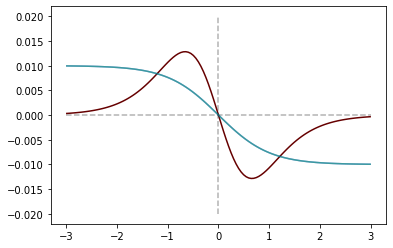

In [88]:
plot_wtc(wtc)

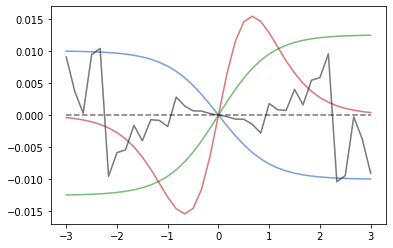

In [67]:
normz=True
for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(0 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(tanh(w[1])/80 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0,.5,0, 0.3])
    
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d2_tanh(w[1])/25 for w in wtc if w[0]==trial_counter],
                 color=[.7, 0,0, 0.3])
    
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2]-tanh(w[1])/-100)*100000  for w in wtc if w[0]==trial_counter],
                 color=[0, 0,0 , 0.3])


In [90]:
#  ^ probably numerical error and floating point precision error?

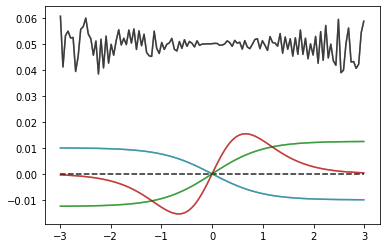

In [89]:
normz=True
for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(0 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(tanh(w[1])/80 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0,.5,0, 0.3])
    
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d2_tanh(w[1])/25 for w in wtc if w[0]==trial_counter],
                 color=[.7, 0,0, 0.3])
    
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2]-tanh(w[1])/-100)*100000  for w in wtc if w[0]==trial_counter],
                 color=[0, 0,0 , 0.3])


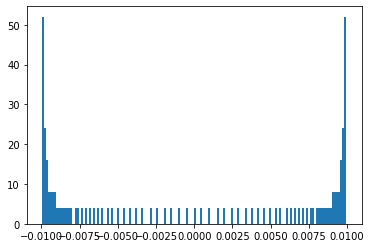

In [86]:
_=plt.hist([w[2] for w in wtc],150)

In [64]:
# 8.29 continued. Trying Relu with cross-entropy loss.

Nonlinearity=('relu', tf.keras.activations.relu)

Y_data = [1.]
X_data = [ np.ones((1,),dtype=float) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-1,2,40)
N_trials = 2
learning_rate=.01
wtc_20_1=query_manual_model_wrapper(n_epochs=20)
wtc_1_1=query_manual_model_wrapper(n_epochs=1)
wtc_100_1=query_manual_model_wrapper(n_epochs=100)

Y_data = [0.]
wtc_20_0=query_manual_model_wrapper(n_epochs=20)
wtc_1_0=query_manual_model_wrapper(n_epochs=1)
wtc_100_0=query_manual_model_wrapper(n_epochs=100)

# plot_wtc(wtc)

trial 1/2 with 20 epochs, iter 0 of 121
trial 1/2 with 20 epochs, iter 100 of 121
trial 2/2 with 20 epochs, iter 79 of 121
done
trial 1/2, iter 0 of 121
trial 1/2, iter 100 of 121
trial 2/2, iter 79 of 121
done
trial 1/2 with 100 epochs, iter 0 of 121
trial 1/2 with 100 epochs, iter 100 of 121
trial 2/2 with 100 epochs, iter 79 of 121
done
trial 1/2 with 20 epochs, iter 0 of 121


<ipython-input-13-206fc78f3e0d>:39: RuntimeWarning: invalid value encountered in subtract
  change = changes_inbox[-1]-weights_inbox[-1]


trial 1/2 with 20 epochs, iter 100 of 121
trial 2/2 with 20 epochs, iter 79 of 121
done
trial 1/2, iter 0 of 121
trial 1/2, iter 100 of 121
trial 2/2, iter 79 of 121
done
trial 1/2 with 100 epochs, iter 0 of 121
trial 1/2 with 100 epochs, iter 100 of 121
trial 2/2 with 100 epochs, iter 79 of 121
done


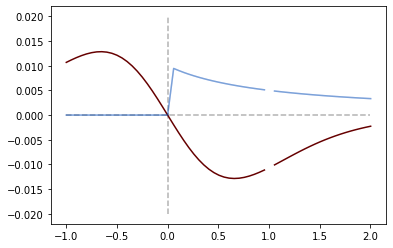

In [23]:
plot_wtc(wtc)

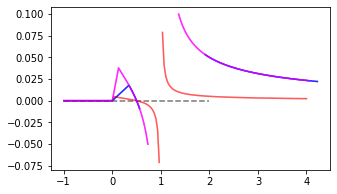

In [68]:
# y = 0.5
normz=True
fig,ax=plt.subplots(1,1,figsize=(5,3))
for trial_counter in range(N_trials):
    ax.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    ax.plot([w[1] for w in wtc_1  if w[0]==trial_counter],  # y=0.5, trained for 1 epoch
            [w[2] for w in wtc_1  if w[0]==trial_counter],color=(1,0,0,0.4))
    ax.plot([w[1] for w in wtc100 if w[0]==trial_counter], # y=0.5, trained for 100 epochs
            [w[2]*10 for w in wtc100 if w[0]==trial_counter],color=(0,0,1,0.6))
    ax.plot([w[1] for w in wtc_20 if w[0]==trial_counter], # y=0.5, trained for 20 epochs
            [w[2]*10 for w in wtc_20 if w[0]==trial_counter],color=(1,0,1,0.6))
    # and w[1]>-.1 and w[1]<.3

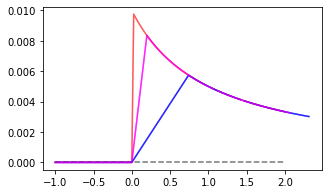

In [67]:
# y=1
normz=True
fig,ax=plt.subplots(1,1,figsize=(5,3))
for trial_counter in range(N_trials):
    ax.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    ax.plot([w[1] for w in wtc_1_1  if w[0]==trial_counter],  # y=0.5, trained for 1 epoch
            [w[2] for w in wtc_1_1  if w[0]==trial_counter],color=(1,0,0,0.4))
    ax.plot([w[1] for w in wtc_100_1 if w[0]==trial_counter], # y=0.5, trained for 100 epochs
            [w[2] for w in wtc_100_1 if w[0]==trial_counter],color=(0,0,1,0.6))
    ax.plot([w[1] for w in wtc_20_1 if w[0]==trial_counter], # y=0.5, trained for 20 epochs
            [w[2] for w in wtc_20_1 if w[0]==trial_counter],color=(1,0,1,0.6))

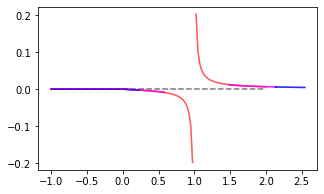

In [69]:
# y=0
normz=True
fig,ax=plt.subplots(1,1,figsize=(5,3))
for trial_counter in range(N_trials):
    ax.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    ax.plot([w[1] for w in wtc_1_0  if w[0]==trial_counter],  # y=0.5, trained for 1 epoch
            [w[2] for w in wtc_1_0  if w[0]==trial_counter],color=(1,0,0,0.4))
    ax.plot([w[1] for w in wtc_20_0 if w[0]==trial_counter], # y=0.5, trained for 20 epochs
            [w[2] for w in wtc_20_0 if w[0]==trial_counter],color=(1,0,1,0.6))
    ax.plot([w[1] for w in wtc_100_0 if w[0]==trial_counter], # y=0.5, trained for 100 epochs
            [w[2] for w in wtc_100_0 if w[0]==trial_counter],color=(0,0,1,0.6))

In [87]:
Y_data = [0.50]
X_data = [ np.ones((1,),dtype=float) for v in Y_data ]     # x_counter
wtc_20_steady=query_manual_model_wrapper(n_epochs=20)
wtc_100_steady=query_manual_model_wrapper(n_epochs=100)

Y_data = [0.51]
X_data = [ np.ones((1,),dtype=float) for v in Y_data ]     # x_counter
wtc_20_jitter=query_manual_model_wrapper(n_epochs=20)
wtc_100_jitter=query_manual_model_wrapper(n_epochs=100)

trial 1/2 with 20 epochs, iter 0 of 121


<ipython-input-13-206fc78f3e0d>:39: RuntimeWarning: invalid value encountered in subtract
  change = changes_inbox[-1]-weights_inbox[-1]


trial 1/2 with 20 epochs, iter 100 of 121
trial 2/2 with 20 epochs, iter 79 of 121
done
trial 1/2 with 100 epochs, iter 0 of 121
trial 1/2 with 100 epochs, iter 100 of 121
trial 2/2 with 100 epochs, iter 79 of 121
done
trial 1/2 with 20 epochs, iter 0 of 121
trial 1/2 with 20 epochs, iter 100 of 121
trial 2/2 with 20 epochs, iter 79 of 121
done
trial 1/2 with 100 epochs, iter 0 of 121
trial 1/2 with 100 epochs, iter 100 of 121
trial 2/2 with 100 epochs, iter 79 of 121
done


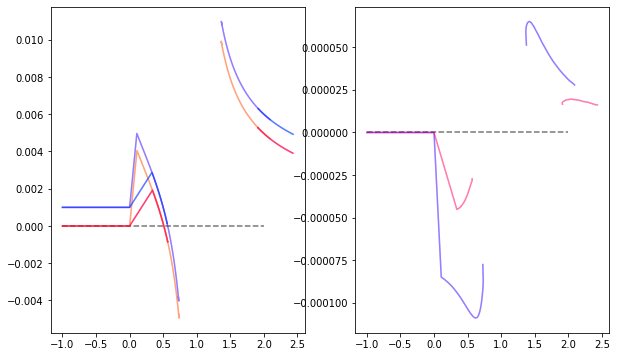

In [89]:
fig,ax=plt.subplots(1,2,figsize=(10,6), sharey=False)
for trial_counter in range(N_trials):
    ax[0].plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    ax[0].plot( [w[1] for w in wtc_20_jitter  if w[0]==trial_counter], # y=0.5, trained for 20 epochs
                [w[2] for w in wtc_20_jitter  if w[0]==trial_counter],color=(1,.3,0,0.3))
    ax[0].plot( [w[1] for w in wtc_100_jitter if w[0]==trial_counter], # y=0.5, trained for 100 epochs
                [w[2] for w in wtc_100_jitter if w[0]==trial_counter],color=(1,0,.3,0.5))
    ax[0].plot( [w[1] for w in wtc_20_steady  if w[0]==trial_counter], # y=0.5, trained for 20 epochs
                [w[2]+.001 for w in wtc_20_steady  if w[0]==trial_counter],color=(.2,0,1,0.3))
    ax[0].plot( [w[1] for w in wtc_100_steady if w[0]==trial_counter], # y=0.5, trained for 100 epochs
                [w[2]+.001 for w in wtc_100_steady if w[0]==trial_counter],color=(0,.2,1,0.4))
 

    ax[1].plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    w20s_1 = [w[1] for w in wtc_20_steady  if w[0]==trial_counter]
    w20s_2 = [w[2] for w in wtc_20_steady  if w[0]==trial_counter]
    w20j_2 = [w[2] for w in wtc_20_jitter  if w[0]==trial_counter]
    w100s_1 = [w[1] for w in wtc_100_steady  if w[0]==trial_counter]
    w100s_2 = [w[2] for w in wtc_100_steady  if w[0]==trial_counter]
    w100j_2 = [w[2] for w in wtc_100_jitter  if w[0]==trial_counter]
   
    ax[1].plot(  w20s_1, [  w20s_2[i] -w20j_2[i] for i in range(len( w20s_1))], color=(.2,0,1,0.3))
    ax[1].plot( w100s_1, [ w100s_2[i]-w100j_2[i] for i in range(len(w100s_1))], color=(1,0,.4,0.3))


In [ ]:
Weights, bounds = weights_range(-0.3,2.5,30)
N_trials = 3

Y_data = [0.50]
X_data = [ np.ones((1,),dtype=float) for v in Y_data ]     # x_counter
wtc_5_steady=query_manual_model_wrapper(n_epochs=5)
wtc_10_steady=query_manual_model_wrapper(n_epochs=10)

Y_data = [0.51]
X_data = [ np.ones((1,),dtype=float) for v in Y_data ]     # x_counter
wtc_5_jitter=query_manual_model_wrapper(n_epochs=5)
wtc_10_jitter=query_manual_model_wrapper(n_epochs=10)


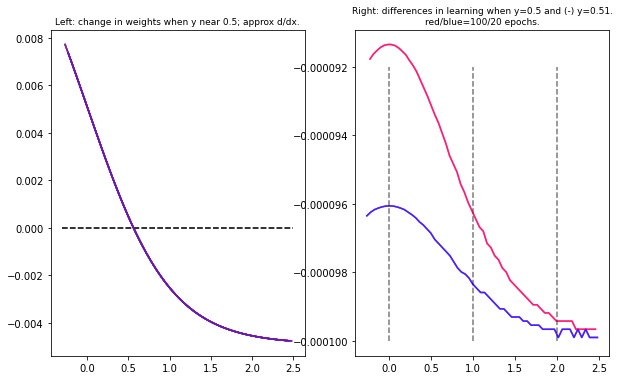

In [105]:
fig,ax=plt.subplots(1,2,figsize=(10,6), sharey=False)
for trial_counter in range(N_trials):
    ax[0].plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    ax[0].plot( [w[1] for w in wtc_5_jitter  if w[0]==trial_counter], # y=0.5, trained for 20 epochs
                [w[2] for w in wtc_5_jitter  if w[0]==trial_counter],color=(1,.3,0,0.3))
    ax[0].plot( [w[1] for w in wtc_10_jitter if w[0]==trial_counter], # y=0.5, trained for 100 epochs
                [w[2] for w in wtc_10_jitter if w[0]==trial_counter],color=(1,0,.3,0.5))
    ax[0].plot( [w[1] for w in wtc_5_steady  if w[0]==trial_counter], # y=0.5, trained for 20 epochs
                [w[2]+.0001 for w in wtc_5_steady  if w[0]==trial_counter],color=(.2,0,1,0.3))
    ax[0].plot( [w[1] for w in wtc_10_steady if w[0]==trial_counter], # y=0.5, trained for 100 epochs
                [w[2]+.0001 for w in wtc_10_steady if w[0]==trial_counter],color=(0,.2,1,0.4))
    ax[0].set_title('Left: change in weights when y near 0.5; approx d/dx.', fontsize=9)
    
#    ax[1].plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    ax[1].plot([0,0],[-.0001,-.000092], '--', color=[0,0,0,0.1])
    ax[1].plot([1,1],[-.0001,-.000092], '--', color=[0,0,0,0.1])
    ax[1].plot([2,2],[-.0001,-.000092], '--', color=[0,0,0,0.1])

    w5s_1 = [w[1] for w in wtc_5_steady  if w[0]==trial_counter]
    w5s_2 = [w[2] for w in wtc_5_steady  if w[0]==trial_counter]
    w5j_2 = [w[1] for w in wtc_5_jitter  if w[0]==trial_counter]
    w5j_2 = [w[2] for w in wtc_5_jitter  if w[0]==trial_counter]
    w10s_1 = [w[1] for w in wtc_10_steady  if w[0]==trial_counter]
    w10s_2 = [w[2] for w in wtc_10_steady  if w[0]==trial_counter]
    w10j_1 = [w[1] for w in wtc_10_jitter  if w[0]==trial_counter]
    w10j_2 = [w[2] for w in wtc_10_jitter  if w[0]==trial_counter]
   
    ax[1].plot( w5s_1,  [ w5s_2[i]-w5j_2[i] for i in range(len(w5s_1))], color=(.2,0,1,0.3))
    ax[1].plot( w10j_1, [ w10s_2[i]-w10j_2[i] for i in range(len(w10s_1))], color=(1,0,.4,0.3))
    ax[1].set_title('Right: differences in learning when y=0.5 and (-) y=0.51.\nred/blue=100/20 epochs.', fontsize=9)
    


noise-follows-D4-notebook - Jupyter Notebook
http://127.0.0.1:8001/notebooks/noise-follows-D4-notebook.ipynb

Focal Loss for Dense Object Detection, Tsung-Yi Lin Priya Goyal Ross Girshick Kaiming He Piotr Doll, 2018
https://arxiv.org/pdf/1708.02002.pdf

python - Keras - Implementation of custom loss function with multiple outputs - Data Science Stack Exchange
https://datascience.stackexchange.com/questions/63414/keras-implementation-of-custom-loss-function-with-multiple-outputs

neural network - Keras Custom Loss Function - Data Science Stack Exchange
https://datascience.stackexchange.com/questions/62677/keras-custom-loss-function

tf.keras.losses.Loss  |  TensorFlow v2.9.1
https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss

python - TypeError: Expected float32 passed to parameter 'y' of op 'Equal', got 'auto' of type 'str' instead - Stack Overflow
https://stackoverflow.com/questions/62494412/typeerror-expected-float32-passed-to-parameter-y-of-op-equal-got-auto-of



In [ ]:
# ^ 8.29











trial 0/4, iter 0 of 81
trial 0/4, iter 8 of 81
trial 0/4, iter 16 of 81
trial 0/4, iter 24 of 81
trial 0/4, iter 32 of 81
trial 0/4, iter 40 of 81
trial 0/4, iter 48 of 81
trial 0/4, iter 56 of 81
trial 0/4, iter 64 of 81
trial 0/4, iter 72 of 81
trial 0/4, iter 80 of 81
trial 1/4, iter 0 of 81
trial 1/4, iter 8 of 81
trial 1/4, iter 16 of 81
trial 1/4, iter 24 of 81
trial 1/4, iter 32 of 81
trial 1/4, iter 40 of 81
trial 1/4, iter 48 of 81
trial 1/4, iter 56 of 81
trial 1/4, iter 64 of 81
trial 1/4, iter 72 of 81
trial 1/4, iter 80 of 81
trial 2/4, iter 0 of 81
trial 2/4, iter 8 of 81
trial 2/4, iter 16 of 81
trial 2/4, iter 24 of 81
trial 2/4, iter 32 of 81
trial 2/4, iter 40 of 81
trial 2/4, iter 48 of 81
trial 2/4, iter 56 of 81
trial 2/4, iter 64 of 81
trial 2/4, iter 72 of 81
trial 2/4, iter 80 of 81
trial 3/4, iter 0 of 81
trial 3/4, iter 8 of 81
trial 3/4, iter 16 of 81
trial 3/4, iter 24 of 81
trial 3/4, iter 32 of 81
trial 3/4, iter 40 of 81
trial 3/4, iter 48 of 81
trial 3/

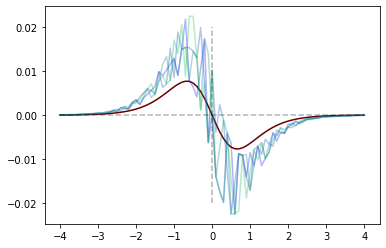

In [164]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-4,4,10)
N_trials = 4
wtc_alt=query_manual_model_wrapper()
plot_wtc(wtc_alt)

trial 0/(0..3), iter 0 of 81
trial 0/(0..3), iter 4 of 81
trial 0/(0..3), iter 8 of 81
trial 0/(0..3), iter 12 of 81
trial 0/(0..3), iter 16 of 81
trial 0/(0..3), iter 20 of 81
trial 0/(0..3), iter 24 of 81
trial 0/(0..3), iter 28 of 81
trial 0/(0..3), iter 32 of 81
trial 0/(0..3), iter 36 of 81
trial 0/(0..3), iter 40 of 81
trial 0/(0..3), iter 44 of 81
trial 0/(0..3), iter 48 of 81
trial 0/(0..3), iter 52 of 81
trial 0/(0..3), iter 56 of 81
trial 0/(0..3), iter 60 of 81
trial 0/(0..3), iter 64 of 81
trial 0/(0..3), iter 68 of 81
trial 0/(0..3), iter 72 of 81
trial 0/(0..3), iter 76 of 81
trial 0/(0..3), iter 80 of 81
trial 1/(0..3), iter 0 of 81
trial 1/(0..3), iter 4 of 81
trial 1/(0..3), iter 8 of 81
trial 1/(0..3), iter 12 of 81
trial 1/(0..3), iter 16 of 81
trial 1/(0..3), iter 20 of 81
trial 1/(0..3), iter 24 of 81
trial 1/(0..3), iter 28 of 81
trial 1/(0..3), iter 32 of 81
trial 1/(0..3), iter 36 of 81
trial 1/(0..3), iter 40 of 81
trial 1/(0..3), iter 44 of 81
trial 1/(0..3), 

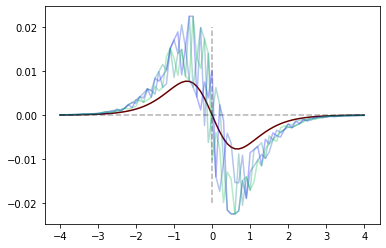

In [166]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-4,4,10)
N_trials = 4
wtc_alt=query_manual_model_wrapper()
plot_wtc(wtc_alt)

In [28]:
Y_data = [1,0.5,-0.5,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,10)
N_trials = 3
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=4, batchsize=2)
plot_wtc(wtc, normz=True)


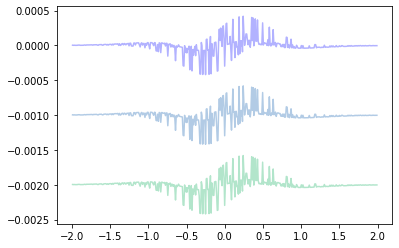

In [232]:
for trial_counter in range(N_trials):
#     plt.plot([w[1] for w in wtc if w[0]==0], 
#                  [w[2] +1e-3*trial_counter for w in wtc if w[0]==0],
#                  color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==0], 
                 [w[2] -(d2_tanh(w[1])/-25+1e-3*trial_counter if normz else 0) for w in wtc if w[0]==0],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])
# plt.plot([w[1] for w in wtc if w[0]==0], 
#              [d2_tanh(w[1])/-25+0*shift for w in wtc if w[0]==0],
#              color=[0.4,0,0])

trial 1/3, iter 0 of 241
trial 1/3, iter 8 of 241
trial 1/3, iter 16 of 241
trial 1/3, iter 24 of 241
trial 1/3, iter 32 of 241
trial 1/3, iter 40 of 241
trial 1/3, iter 48 of 241
trial 1/3, iter 56 of 241
trial 1/3, iter 64 of 241
trial 1/3, iter 72 of 241
trial 1/3, iter 80 of 241
trial 1/3, iter 88 of 241
trial 1/3, iter 96 of 241
trial 1/3, iter 104 of 241
trial 1/3, iter 112 of 241
trial 1/3, iter 120 of 241
trial 1/3, iter 128 of 241
trial 1/3, iter 136 of 241
trial 1/3, iter 144 of 241
trial 1/3, iter 152 of 241
trial 1/3, iter 160 of 241
trial 1/3, iter 168 of 241
trial 1/3, iter 176 of 241
trial 1/3, iter 184 of 241
trial 1/3, iter 192 of 241
trial 1/3, iter 200 of 241
trial 1/3, iter 208 of 241
trial 1/3, iter 216 of 241
trial 1/3, iter 224 of 241
trial 1/3, iter 232 of 241
trial 1/3, iter 240 of 241
trial 2/3, iter 0 of 241
trial 2/3, iter 8 of 241
trial 2/3, iter 16 of 241
trial 2/3, iter 24 of 241
trial 2/3, iter 32 of 241
trial 2/3, iter 40 of 241
trial 2/3, iter 48 of 24

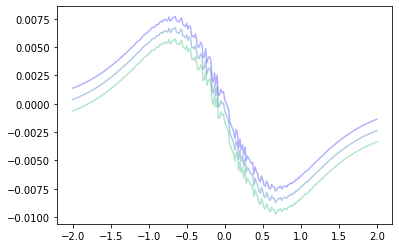

In [238]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,60)
N_trials = 3
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)
#plot_wtc(wtc, normz=True)
for trial_counter in range(N_trials):
    plt.plot([w[1] for w in wtc if w[0]==0], 
                 [w[2] -(d2_tanh(w[1])/-25+1e-3*trial_counter if normz else 0) for w in wtc if w[0]==0],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

trial 1/3, iter 0 of 481
trial 1/3, iter 10 of 481
trial 1/3, iter 20 of 481
trial 1/3, iter 30 of 481
trial 1/3, iter 40 of 481
trial 1/3, iter 50 of 481
trial 1/3, iter 60 of 481
trial 1/3, iter 70 of 481
trial 1/3, iter 80 of 481
trial 1/3, iter 90 of 481
trial 1/3, iter 100 of 481
trial 1/3, iter 110 of 481
trial 1/3, iter 120 of 481
trial 1/3, iter 130 of 481
trial 1/3, iter 140 of 481
trial 1/3, iter 150 of 481
trial 1/3, iter 160 of 481
trial 1/3, iter 170 of 481
trial 1/3, iter 180 of 481
trial 1/3, iter 190 of 481
trial 1/3, iter 200 of 481
trial 1/3, iter 210 of 481
trial 1/3, iter 220 of 481
trial 1/3, iter 230 of 481
trial 1/3, iter 240 of 481
trial 1/3, iter 250 of 481
trial 1/3, iter 260 of 481
trial 1/3, iter 270 of 481
trial 1/3, iter 280 of 481
trial 1/3, iter 290 of 481
trial 1/3, iter 300 of 481
trial 1/3, iter 310 of 481
trial 1/3, iter 320 of 481
trial 1/3, iter 330 of 481
trial 1/3, iter 340 of 481
trial 1/3, iter 350 of 481
trial 1/3, iter 360 of 481
trial 1/3, i

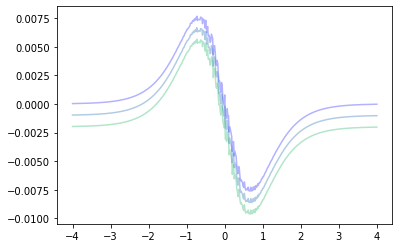

In [275]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-4,4,60)
N_trials = 3
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)
#plot_wtc(wtc, normz=True)
for trial_counter in range(N_trials):
    plt.plot([w[1] for w in wtc if w[0]==0], 
                 [w[2] -(d2_tanh(w[1])/-25+1e-3*trial_counter if normz else 0) for w in wtc if w[0]==0],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

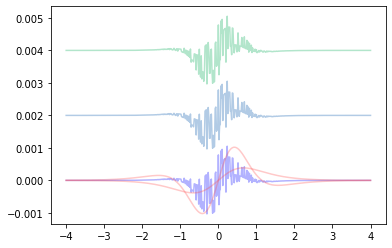

In [286]:
for trial_counter in range(N_trials):
#     plt.plot([w[1] for w in wtc if w[0]==0], 
#                  [w[2] -(d2_tanh(w[1])/-1+1e-7*trial_counter if normz else 0) for w in wtc if w[0]==0],
#                  color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==0], 
                 [w[2]+d2_tanh(w[1])*0.06+1e-3*2*trial_counter for w in wtc if w[0]==0],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])
plt.plot([w[1] for w in wtc if w[0]==0], 
                 [d4_tanh(w[1])/2000 for w in wtc if w[0]==0],
                 color=[1,.3,.3, 0.3])
plt.plot([w[1] for w in wtc if w[0]==0], 
                 [d2_tanh(w[1])/1000 for w in wtc if w[0]==0],
                 color=[1,.3,.3, 0.3])

trial 1/2, iter 0 of 81
trial 1/2, iter 8 of 81
trial 1/2, iter 16 of 81
trial 1/2, iter 24 of 81
trial 1/2, iter 32 of 81
trial 1/2, iter 40 of 81
trial 1/2, iter 48 of 81
trial 1/2, iter 56 of 81
trial 1/2, iter 64 of 81
trial 1/2, iter 72 of 81
trial 1/2, iter 80 of 81
trial 2/2, iter 0 of 81
trial 2/2, iter 8 of 81
trial 2/2, iter 16 of 81
trial 2/2, iter 24 of 81
trial 2/2, iter 32 of 81
trial 2/2, iter 40 of 81
trial 2/2, iter 48 of 81
trial 2/2, iter 56 of 81
trial 2/2, iter 64 of 81
trial 2/2, iter 72 of 81
trial 2/2, iter 80 of 81
done


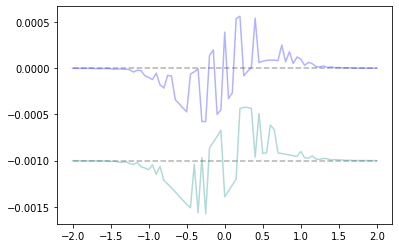

In [298]:
Y_data = [1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,20)
N_trials = 2
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)
#plot_wtc(wtc, normz=True)

for trial_counter in range(N_trials):
    plt.plot(bounds,[-1e-3*trial_counter,-1e-3*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25+1e-3*trial_counter if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

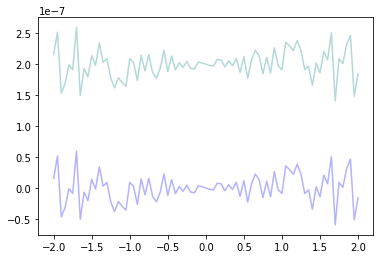

In [318]:
Y_data = [1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,20)
N_trials = 2
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=2)
#plot_wtc(wtc, normz=True)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [.0000002*trial_counter+w[2] -1*(d2_tanh(w[1])/-50 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

trial 1/2, iter 0 of 81
trial 1/2, iter 8 of 81
trial 1/2, iter 16 of 81
trial 1/2, iter 24 of 81
trial 1/2, iter 32 of 81
trial 1/2, iter 40 of 81
trial 1/2, iter 48 of 81
trial 1/2, iter 56 of 81
trial 1/2, iter 64 of 81
trial 1/2, iter 72 of 81
trial 1/2, iter 80 of 81
trial 2/2, iter 0 of 81
trial 2/2, iter 8 of 81
trial 2/2, iter 16 of 81
trial 2/2, iter 24 of 81
trial 2/2, iter 32 of 81
trial 2/2, iter 40 of 81
trial 2/2, iter 48 of 81
trial 2/2, iter 56 of 81
trial 2/2, iter 64 of 81
trial 2/2, iter 72 of 81
trial 2/2, iter 80 of 81
done


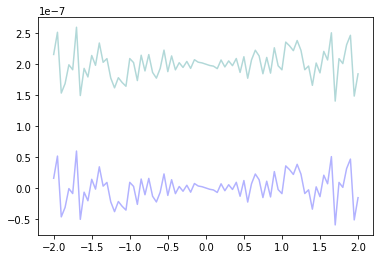

In [319]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,20)
N_trials = 2
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=3)
#plot_wtc(wtc, normz=True)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [.0000002*trial_counter+w[2] -1*(d2_tanh(w[1])/-50 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])
print('change in weights = d2')

trial 1/2, iter 0 of 81
trial 1/2, iter 8 of 81
trial 1/2, iter 16 of 81
trial 1/2, iter 24 of 81
trial 1/2, iter 32 of 81
trial 1/2, iter 40 of 81
trial 1/2, iter 48 of 81
trial 1/2, iter 56 of 81
trial 1/2, iter 64 of 81
trial 1/2, iter 72 of 81
trial 1/2, iter 80 of 81
trial 2/2, iter 0 of 81
trial 2/2, iter 8 of 81
trial 2/2, iter 16 of 81
trial 2/2, iter 24 of 81
trial 2/2, iter 32 of 81
trial 2/2, iter 40 of 81
trial 2/2, iter 48 of 81
trial 2/2, iter 56 of 81
trial 2/2, iter 64 of 81
trial 2/2, iter 72 of 81
trial 2/2, iter 80 of 81
done


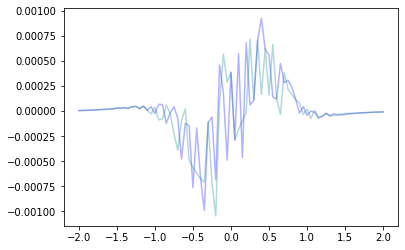

In [325]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,20)
N_trials = 2
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [.0000002*trial_counter+w[2] -1*(d2_tanh(w[1])*-0.06 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])


trial 1/2, iter 0 of 81
trial 1/2, iter 8 of 81
trial 1/2, iter 16 of 81
trial 1/2, iter 24 of 81
trial 1/2, iter 32 of 81
trial 1/2, iter 40 of 81
trial 1/2, iter 48 of 81
trial 1/2, iter 56 of 81
trial 1/2, iter 64 of 81
trial 1/2, iter 72 of 81
trial 1/2, iter 80 of 81
trial 2/2, iter 0 of 81
trial 2/2, iter 8 of 81
trial 2/2, iter 16 of 81
trial 2/2, iter 24 of 81
trial 2/2, iter 32 of 81
trial 2/2, iter 40 of 81
trial 2/2, iter 48 of 81
trial 2/2, iter 56 of 81
trial 2/2, iter 64 of 81
trial 2/2, iter 72 of 81
trial 2/2, iter 80 of 81
done


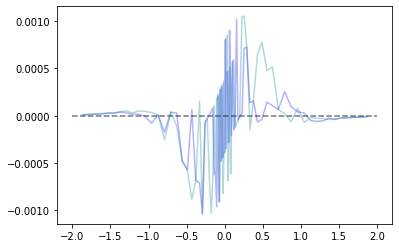

In [327]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,20)
N_trials = 2
# wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [.0000000*trial_counter+w[2] -1*(d2_tanh(w[1])*-0.06 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])


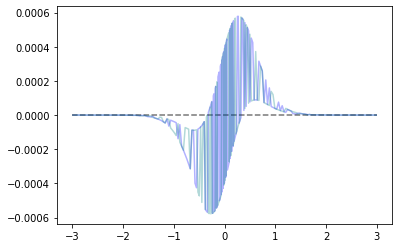

In [334]:
Y_data = [1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 2
# wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

trial 1/1, iter 0 of 241
trial 1/1, iter 24 of 241
trial 1/1, iter 48 of 241
trial 1/1, iter 72 of 241
trial 1/1, iter 96 of 241
trial 1/1, iter 120 of 241
trial 1/1, iter 144 of 241
trial 1/1, iter 168 of 241
trial 1/1, iter 192 of 241
trial 1/1, iter 216 of 241
trial 1/1, iter 240 of 241
done


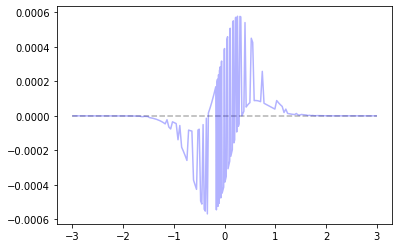

In [340]:
# verify....
Y_data = [1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 1
wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

trial 1/1, iter 0 of 241
trial 1/1, iter 24 of 241
trial 1/1, iter 48 of 241
trial 1/1, iter 72 of 241
trial 1/1, iter 96 of 241
trial 1/1, iter 120 of 241
trial 1/1, iter 144 of 241
trial 1/1, iter 168 of 241
trial 1/1, iter 192 of 241
trial 1/1, iter 216 of 241
trial 1/1, iter 240 of 241
done


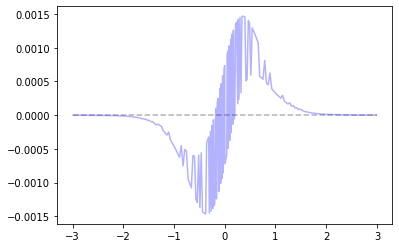

In [341]:
Y_data = [2,-2]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 1
wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

trial 1/1, iter 0 of 241
trial 1/1, iter 24 of 241
trial 1/1, iter 48 of 241
trial 1/1, iter 72 of 241
trial 1/1, iter 96 of 241
trial 1/1, iter 120 of 241
trial 1/1, iter 144 of 241
trial 1/1, iter 168 of 241
trial 1/1, iter 192 of 241
trial 1/1, iter 216 of 241
trial 1/1, iter 240 of 241
done


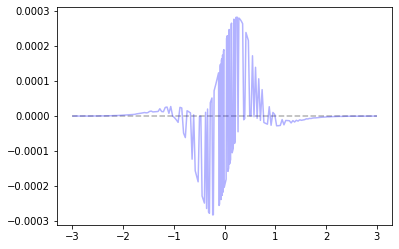

In [342]:
Y_data = [.5,-.5]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 1
wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

trial 1/1, iter 0 of 241
trial 1/1, iter 24 of 241
trial 1/1, iter 48 of 241
trial 1/1, iter 72 of 241
trial 1/1, iter 96 of 241
trial 1/1, iter 120 of 241
trial 1/1, iter 144 of 241
trial 1/1, iter 168 of 241
trial 1/1, iter 192 of 241
trial 1/1, iter 216 of 241
trial 1/1, iter 240 of 241
done


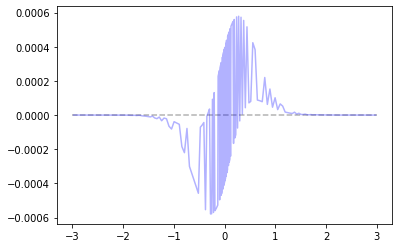

In [343]:
Y_data = [1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 1
wtc=query_manual_model_wrapper(n_epochs=60, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

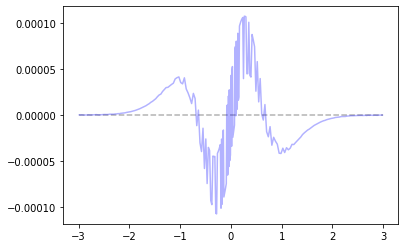

In [349]:
Y_data = [.1,-.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 1
#wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

normz=True

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

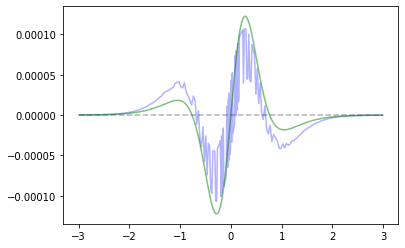

In [386]:
for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] + (d2_tanh(w[1])/25 - d4_tanh(w[1])*2.5e-15
                             if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d4_tanh(1.5*w[1])*6e-5 for w in wtc if w[0]==trial_counter],
                 color=[0, .5,0, 0.5])

trial 1/1, iter 0 of 421
trial 1/1, iter 25 of 421
trial 1/1, iter 50 of 421
trial 1/1, iter 75 of 421
trial 1/1, iter 100 of 421
trial 1/1, iter 125 of 421
trial 1/1, iter 150 of 421
trial 1/1, iter 175 of 421
trial 1/1, iter 200 of 421
trial 1/1, iter 225 of 421
trial 1/1, iter 250 of 421
trial 1/1, iter 275 of 421
trial 1/1, iter 300 of 421
trial 1/1, iter 325 of 421
trial 1/1, iter 350 of 421
trial 1/1, iter 375 of 421
trial 1/1, iter 400 of 421
done


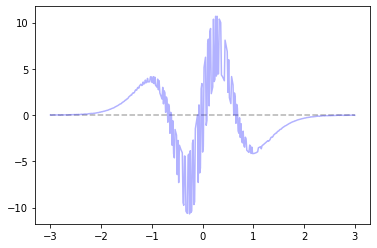

In [407]:
Y_data = [-.1,.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,70)
N_trials = 1
normz=True
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)


for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2] -(d2_tanh(w[1])/-25 if normz else 0))*1e5 for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

^^ alpha: ~0.33, gamma: ~0.73, delta: ~1

trial 1/1, iter 0 of 421
trial 1/1, iter 25 of 421
trial 1/1, iter 50 of 421
trial 1/1, iter 75 of 421
trial 1/1, iter 100 of 421
trial 1/1, iter 125 of 421
trial 1/1, iter 150 of 421
trial 1/1, iter 175 of 421
trial 1/1, iter 200 of 421
trial 1/1, iter 225 of 421
trial 1/1, iter 250 of 421
trial 1/1, iter 275 of 421
trial 1/1, iter 300 of 421
trial 1/1, iter 325 of 421
trial 1/1, iter 350 of 421
trial 1/1, iter 375 of 421
trial 1/1, iter 400 of 421
done


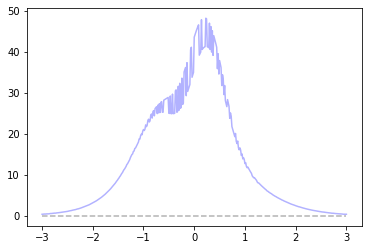

In [409]:
Y_data = [-.09,.11]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,70)
N_trials = 1
normz=True
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)


for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2] -(d2_tanh(w[1])/-25 if normz else 0))*1e5 for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

trial 1/1, iter 0 of 421
trial 1/1, iter 25 of 421
trial 1/1, iter 50 of 421
trial 1/1, iter 75 of 421
trial 1/1, iter 100 of 421
trial 1/1, iter 125 of 421
trial 1/1, iter 150 of 421
trial 1/1, iter 175 of 421
trial 1/1, iter 200 of 421
trial 1/1, iter 225 of 421
trial 1/1, iter 250 of 421
trial 1/1, iter 275 of 421
trial 1/1, iter 300 of 421
trial 1/1, iter 325 of 421
trial 1/1, iter 350 of 421
trial 1/1, iter 375 of 421
trial 1/1, iter 400 of 421
done


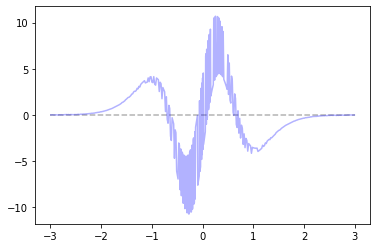

In [410]:
Y_data = [-.1,.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,70)
N_trials = 1
normz=True
wtc=query_manual_model_wrapper(n_epochs=20, batchsize=1)


for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2] -(d2_tanh(w[1])/-25 if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

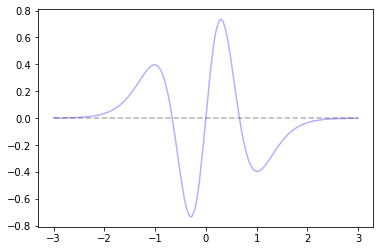

In [413]:
Y_data = [-.001,.001]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,70)
N_trials = 1
normz=True
#wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)


for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2] -(d2_tanh(w[1])/-25 if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

^ 12.5/40 pixels, 27/40 pixels, 41/40 pixels are alpha/gamma/delta. Alpha peak is 42 vs delta's 79 = 1.881x difference.

Off of this, I investigated:
d4_alt(x,s) = d2(x,s) * d/dx d2(x,s)
            = (s(x) d/dx s(x)) * d/dx (s(x) d/dx s(x))
            = tanh(x) sech^2(x) (sech^4(x) - 2 tanh^2(x) sech^2(x)) if s=tanh
This yields alpha/gamma/delta: 0.293, 0.658, 1.008 , = 11.7/40, 26.3/40, 40.3/40 which is probably a match, then.

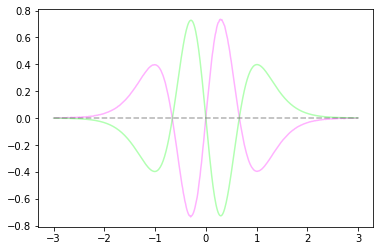

In [570]:
Y_data = [-.001,.001]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,70)
N_trials = 1
normz=True
#wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)


for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2] -(d2_tanh(w[1])/-25 if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[1, 0, 1, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [-d4_tanh_new(w[1])*4 for w in wtc if w[0]==trial_counter],
                 color=[0, 1, 0, 0.3])    

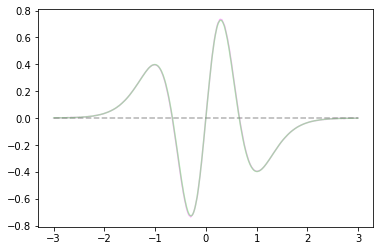

In [571]:
for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2] -(d2_tanh(w[1])/-25 if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[1, 0, 1, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d4_tanh_new(w[1])*4 for w in wtc if w[0]==trial_counter],
                 color=[0, 1, 0, 0.3]) 

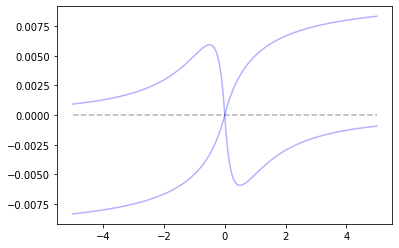

In [427]:
Y_data = [-.01,.01]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-5,5,40)
N_trials = 1
normz=True
Nonlinearity= ('softsign',  tf.keras.activations.softsign )
# wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)

def softsign(x): return x/(1+abs(x))
def d2_softsign(x): return x/(1+abs(x))**3

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])
plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[1]/(1+abs(w[1]))*1e-2 for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

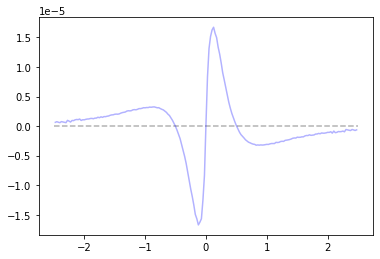

In [439]:
for trial_counter in range(N_trials):
    plt.plot([-2.5,2.5],[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and abs(w[1])<2.5], 
                 [w[2]-d2_softsign(-w[1])*4e-2 for w in wtc if w[0]==trial_counter and abs(w[1])<2.5] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])


^ 7/49=0.143, 26/49=0.531, 43/49=0.878.
Original D4, d/dx d/dx ( s(x) * d/dx s(x) ) is discontinuous at 0.
Modified D4, (s(x)*d/dx s(x))*d/dx(s(x)*d/dx s(x)), has alpha/gamma/delta at 0.113, 0.5, 0.887 where the peak at alpha is about 5.5 times greater than the delta peak, and unlike modified D4 whose analytic alpha is 1.830 times greater than the delta peak. 

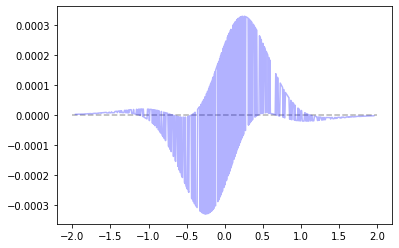

In [514]:
Y_data = [-.6585*0.9,.6585*0.9]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,150)
N_trials = 1
normz=True
Nonlinearity= ('tanh',  tanh )
#wtc=query_manual_model_wrapper(n_epochs=15, batchsize=1)

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2]+d2_tanh(w[1])*.04 for w in wtc if w[0]==trial_counter] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])


trial 1/1, iter 0 of 601
trial 1/1, iter 100 of 601
trial 1/1, iter 200 of 601
trial 1/1, iter 300 of 601
trial 1/1, iter 400 of 601
trial 1/1, iter 500 of 601
trial 1/1, iter 600 of 601
done


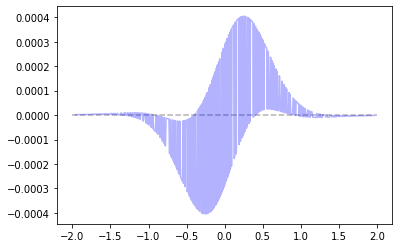

In [515]:
Y_data = [-.6585*1.1,.6585*1.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,150)
N_trials = 1
normz=True
Nonlinearity= ('tanh',  tanh )
wtc=query_manual_model_wrapper(n_epochs=15, batchsize=1)

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2]+d2_tanh(w[1])*.04 for w in wtc if w[0]==trial_counter] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])


trial 1/1 with 50 epochs, iter 0 of 601
trial 1/1 with 50 epochs, iter 100 of 601
trial 1/1 with 50 epochs, iter 200 of 601
trial 1/1 with 50 epochs, iter 300 of 601
trial 1/1 with 50 epochs, iter 400 of 601
trial 1/1 with 50 epochs, iter 500 of 601
trial 1/1 with 50 epochs, iter 600 of 601
done


[(0, -10.0, 0.0), (0, -9.966666, 0.0)]

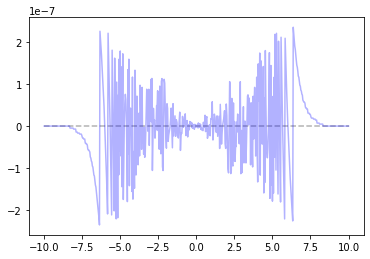

In [527]:
Y_data = [-.6585,.6585]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-10,10,30)
N_trials = 1
normz=True
Nonlinearity= ('tanh',  tanh )
wtc=query_manual_model_wrapper(n_epochs=50, batchsize=2)

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2]+d2_tanh(w[1])*.02 for w in wtc if w[0]==trial_counter] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])
wtc[:2] # epochs=15, weights_range(-2,2,150): [(0, -1.9806097, 0.001412034), (0, -1.973698, 0.0014301538)]

trial 1/1, iter 0 of 601
trial 1/1, iter 100 of 601
trial 1/1, iter 200 of 601
trial 1/1, iter 300 of 601
trial 1/1, iter 400 of 601
trial 1/1, iter 500 of 601
trial 1/1, iter 600 of 601
done


[(0, -10.0, 0.0), (0, -9.966666, 0.0)]

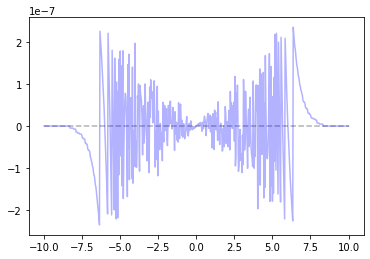

In [528]:
Y_data = [-.6585,.6585]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-10,10,30)
N_trials = 1
normz=True
Nonlinearity= ('tanh',  tanh )
wtc=query_manual_model_wrapper(batchsize=2)

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2]+d2_tanh(w[1])*.02 for w in wtc if w[0]==trial_counter] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])
wtc[:2] # epochs=15, weights_range(-2,2,150): [(0, -1.9806097, 0.001412034), (0, -1.973698, 0.0014301538)]

trial 1/1, iter 0 of 601
trial 1/1, iter 100 of 601
trial 1/1, iter 200 of 601
trial 1/1, iter 300 of 601
trial 1/1, iter 400 of 601
trial 1/1, iter 500 of 601
trial 1/1, iter 600 of 601
done


[(0, -10.0, 0.0), (0, -9.966666, 0.0)]

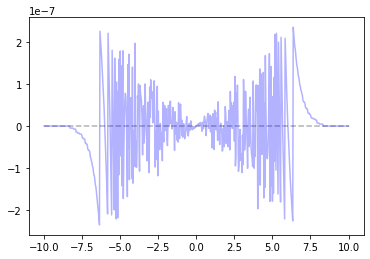

In [529]:
Y_data = [-.65,.65]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-10,10,30)
N_trials = 1
normz=True
Nonlinearity= ('tanh',  tanh )
wtc=query_manual_model_wrapper(batchsize=2)

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2]+d2_tanh(w[1])*.02 for w in wtc if w[0]==trial_counter] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])
wtc[:2] # epochs=15, weights_range(-2,2,150): [(0, -1.9806097, 0.001412034), (0, -1.973698, 0.0014301538)]

trial 1/1, iter 0 of 601
trial 1/1, iter 100 of 601
trial 1/1, iter 200 of 601
trial 1/1, iter 300 of 601
trial 1/1, iter 400 of 601
trial 1/1, iter 500 of 601
trial 1/1, iter 600 of 601
done


[(0, -10.0, 0.0), (0, -9.966666, 0.0)]

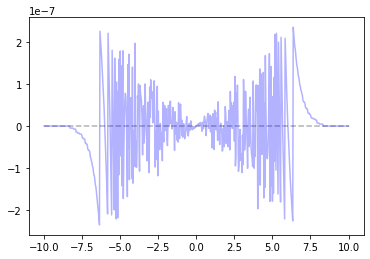

In [530]:
Y_data = [-.7078,.7078]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-10,10,30)
N_trials = 1
normz=True
Nonlinearity= ('tanh',  tanh )
wtc=query_manual_model_wrapper(batchsize=2)

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2]+d2_tanh(w[1])*.02 for w in wtc if w[0]==trial_counter] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])
wtc[:2] # epochs=15, weights_range(-2,2,150): [(0, -1.9806097, 0.001412034), (0, -1.973698, 0.0014301538)]

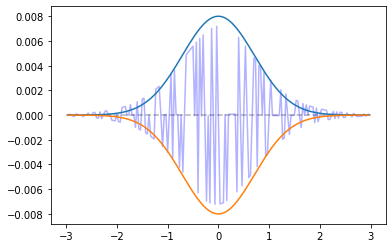

In [546]:
Y_data = [-.7078,0,.7078]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,30)
N_trials = 1
normz=True
Nonlinearity= ('tanh',  tanh )
# wtc=query_manual_model_wrapper(n_epochs=1, batchsize=2)

plot_range = bounds #[-2.5,2.5]
for trial_counter in range(N_trials):
    plt.plot(plot_range,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [w[2]+d2_tanh(w[1])*.04 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])
wtc[:2] # epochs=15, weights_range(-2,2,150): [(0, -1.9806097, 0.001412034), (0, -1.973698, 0.0014301538)]
plt.plot( [w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]],
         [ np.exp(-w[1]**2)*8e-3 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]])
plt.plot( [w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]],
         [-np.exp(-w[1]**2)*8e-3 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]])

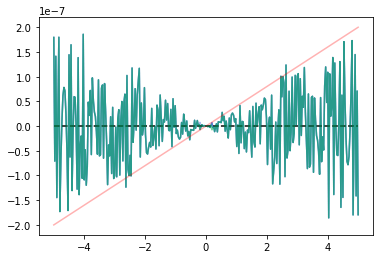

In [558]:
Y_data = [-.7078,0,.7078]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-5,5,30)
N_trials = 5
normz=True
Nonlinearity= ('tanh',  tanh )
#wtc=query_manual_model_wrapper(n_epochs=10, batchsize=3)

plot_range = bounds #[-2.5,2.5]
for trial_counter in range(N_trials):
    plt.plot(plot_range,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [w[2]+d2_tanh(w[1])*.02 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])
wtc[:2] # epochs=15, weights_range(-2,2,150): [(0, -1.9806097, 0.001412034), (0, -1.973698, 0.0014301538)]
plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [w[1]*4e-8 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[1, 0,0, 0.3])


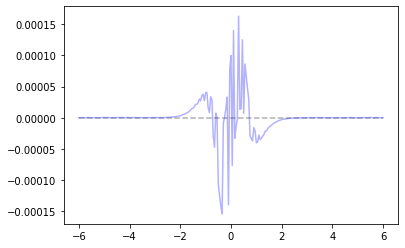

In [488]:
Y_data = [-.25,.25]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-6,6,20)
N_trials = 1
normz=True
Nonlinearity= ('tanh',  tanh )
#wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2]+d2_tanh(w[1])*4e-2 for w in wtc if w[0]==trial_counter] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])


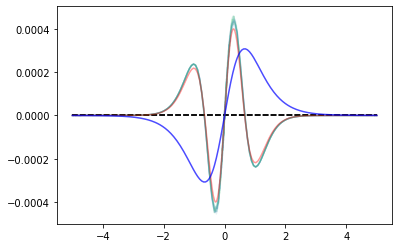

In [49]:
Y_data = [-.02,-.01,.01,.02]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-5,5,30)
N_trials = 10
normz=True
Nonlinearity= ('tanh',  tanh )
#wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

plot_range = bounds #[-2.5,2.5]
for trial_counter in range(N_trials):
    plt.plot(plot_range,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [w[2]+d2_tanh(w[1])*.08 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.1])
wtc[:2] # epochs=15, weights_range(-2,2,150): [(0, -1.9806097, 0.001412034), (0, -1.973698, 0.0014301538)]
plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [d4_tanh_new(w[1])*.0022 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[1, 0,0, 0.4])
plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [d2_tanh(w[1])*.0008 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0, 0,1, 0.7])

trial 1/5 with 100 epochs, iter 0 of 301
trial 1/5 with 100 epochs, iter 100 of 301
trial 1/5 with 100 epochs, iter 200 of 301
trial 1/5 with 100 epochs, iter 300 of 301
trial 2/5 with 100 epochs, iter 99 of 301
trial 2/5 with 100 epochs, iter 199 of 301
trial 2/5 with 100 epochs, iter 299 of 301
trial 3/5 with 100 epochs, iter 98 of 301
trial 3/5 with 100 epochs, iter 198 of 301
trial 3/5 with 100 epochs, iter 298 of 301
trial 4/5 with 100 epochs, iter 97 of 301
trial 4/5 with 100 epochs, iter 197 of 301
trial 4/5 with 100 epochs, iter 297 of 301
trial 5/5 with 100 epochs, iter 96 of 301
trial 5/5 with 100 epochs, iter 196 of 301
trial 5/5 with 100 epochs, iter 296 of 301
done


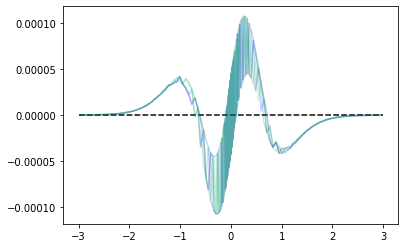

In [80]:
Y_data = [-.1,.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,50)
N_trials = 5
normz=True
Nonlinearity= ('tanh',  tanh )
wtc=query_manual_model_wrapper(n_epochs=100, batchsize=1)

plot_range = bounds #[-2.5,2.5]
for trial_counter in range(N_trials):
    plt.plot(plot_range,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [w[2]+d2_tanh(w[1])*.04 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.2])
    continue
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [w[2]*4e-3     for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0,0,0, 0.2])
if 0:plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [d4_tanh_new(w[1])*.0005 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[1, 0,0, 0.2])


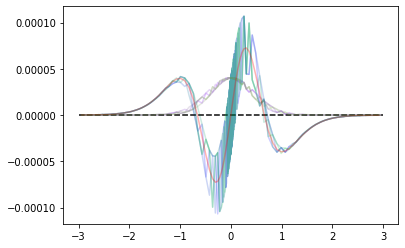

In [92]:
Y_data = [-.1,.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,50)
N_trials = 5
normz=True
Nonlinearity= ('tanh',  tanh )
# wtc=query_manual_model_wrapper(n_epochs=150, batchsize=1)

plot_range = bounds #[-2.5,2.5]
for trial_counter in range(N_trials):
    plt.plot(plot_range,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [w[2]+d2_tanh(w[1])*.04 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.2])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [abs(w[2]+d2_tanh(w[1])*.04 - d4_tanh_new(w[1])*4e-4) for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0.5, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.2]) # variance of sorts; deviation from D4_new.
    continue
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [w[2]*4e-3     for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0,0,0, 0.2])
if 1:plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [d4_tanh_new(w[1])*.0004 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[1, 0,0, 0.3])


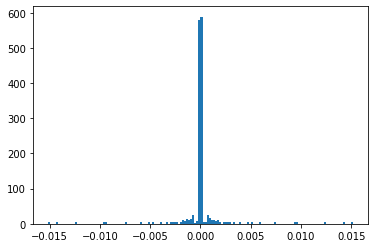

In [127]:
Y_data = [-.1,.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,50)
N_trials = 5
normz=True
Nonlinearity= ('tanh',  tanh )
#wtc=query_manual_model_wrapper(n_epochs=500, batchsize=1)


plt.hist([w[2] for w in wtc],150)
pass

0

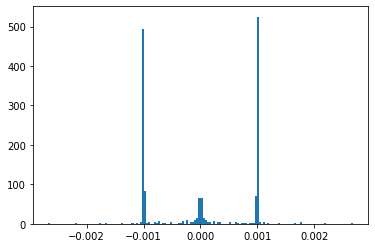

In [191]:
#plt.hist([w[2]+d2_tanh(w[1])/25. for w in wtc],150)
plt.hist([w[2]*25+d2_tanh(w[1]) for w in wtc],150)
0

^ Nice. This is the plot I was hoping to see. Under D2 and D4_new signals and noise, the mostly tend towards zero but some get stuck at the attractors

0

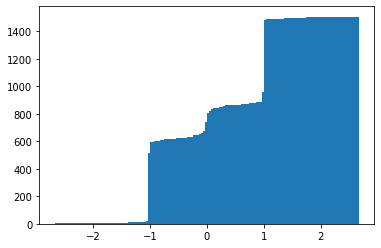

In [184]:
#plt.plot([[sum(wtc[i][2]+d2_tanh(wtc[i][1])/25.) for i in range(j)] for j in range(301)],150)
plt.hist([(w[2]+d2_tanh(w[1])/25.)/4e-5 for w in wtc],150, cumulative=True)
0

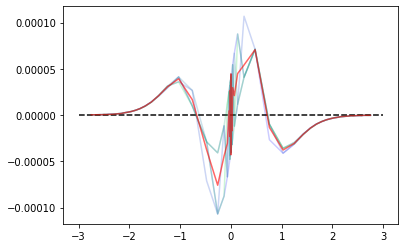

In [169]:
plot_range = bounds #[-2.5,2.5]
for trial_counter in range(N_trials):
    plt.plot(plot_range,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [w[2]+d2_tanh(w[1])*.04 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.2])
    if 0:plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [abs(w[2]+d2_tanh(w[1])*.04 - d4_tanh_new(w[1])*4e-4) for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[0.5, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.2]) # variance of sorts; deviation from D4_new.
avg_wtc2 = [(0.2*sum(wtc[i+j*301][2] for j in range(5))+(d2_tanh(wtc[i][1]))/25.) for i in range(301)]
plt.plot([w[1] for w in wtc if w[0]==0 and plot_range[0]<w[1] and plot_range[1]>w[1]],
        avg_wtc2, color=[1,0,0,0.6])

if 0:plt.plot([w[1] for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
                 [d4_tanh_new(w[1])*.0004 for w in wtc if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]] ,
                 color=[1, 0,0, 0.3])

In [138]:
len(wtc)

1505

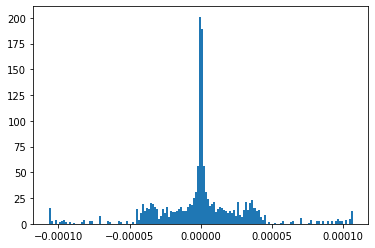

In [124]:
Y_data = [-.1,.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,50)
N_trials = 5
normz=True
Nonlinearity= ('tanh',  tanh )
# wtc_=query_manual_model_wrapper(n_epochs=1, batchsize=1)


# plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
plt.hist([w[2]+d2_tanh(w[1])*.04 for w in wtc_],150)
# plt.plot([w[1] for w in wtc_],[w[2]+d2_tanh(w[1])*.04 for w in wtc_])
pass

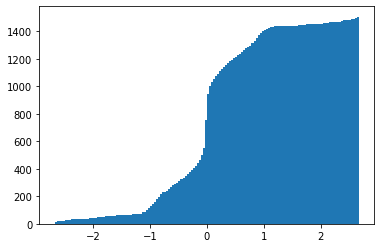

In [185]:
_=plt.hist([(w[2]+d2_tanh(w[1])/25.)/4e-5 for w in wtc_],150, cumulative=True)


trial 1/1, iter 0 of 301
trial 1/1, iter 100 of 301
trial 1/1, iter 200 of 301
trial 1/1, iter 300 of 301
done


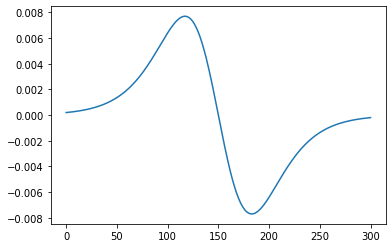

In [209]:
Y_data = [-.1,.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,50)
N_trials = 1
normz=True
Nonlinearity= ('tanh',  tanh )
wtc_01, init_ws_01, final_ws_01=query_manual_model_wrapper(n_epochs=1, batchsize=2, return_raw_weights=True)

_=plt.plot([w[2] for w in wtc_01])

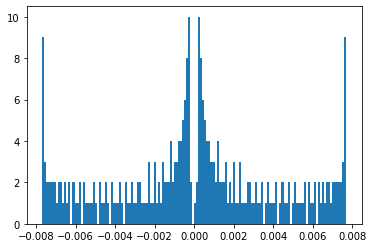

In [210]:
_=plt.hist([w[2] for w in wtc_01],150)

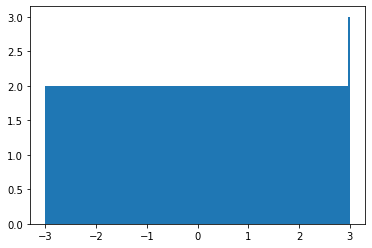

In [216]:
_=plt.hist([w[1] for w in wtc_01],150) # the actual weights

trial 1/1 with 40 epochs, iter 0 of 301
trial 1/1 with 40 epochs, iter 100 of 301
trial 1/1 with 40 epochs, iter 200 of 301
trial 1/1 with 40 epochs, iter 300 of 301
done
trial 1/1 with 40 epochs, iter 0 of 301
trial 1/1 with 40 epochs, iter 100 of 301
trial 1/1 with 40 epochs, iter 200 of 301
trial 1/1 with 40 epochs, iter 300 of 301
done


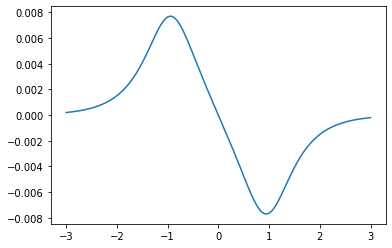

In [241]:
Weights, bounds = weights_range(-3,3,50)
wtc_02=query_manual_model_wrapper(n_epochs=40, batchsize=2)
wtc_02, init_ws_02, final_ws_02 =query_manual_model_wrapper(n_epochs=40, batchsize=2, return_raw_weights=True)

_=plt.plot(Weights,[w[2] for w in wtc_02])

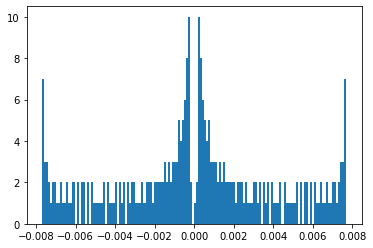

In [242]:
_=plt.hist([w[2] for w in wtc_02],150)

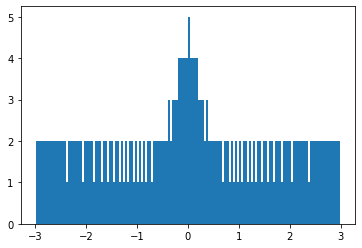

In [243]:
_=plt.hist([w[1] for w in wtc_02],150)

trial 1/1 with 40 epochs, iter 0 of 301
trial 1/1 with 40 epochs, iter 100 of 301
trial 1/1 with 40 epochs, iter 200 of 301
trial 1/1 with 40 epochs, iter 300 of 301
done


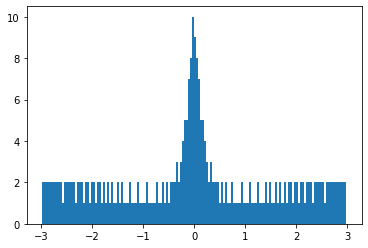

In [221]:
wtc_03 =query_manual_model_wrapper(n_epochs=40, batchsize=1)
_=plt.hist([w[1] for w in wtc_03],150)

trial 1/1 with 250 epochs, iter 0 of 121
trial 1/1 with 250 epochs, iter 100 of 121
done


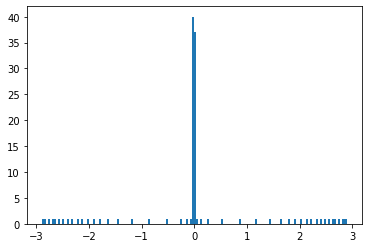

In [244]:
Weights, bounds = weights_range(-3,3,20)
wtc_04 =query_manual_model_wrapper(n_epochs=250, batchsize=1)
_=plt.hist([w[1] for w in wtc_04],150)

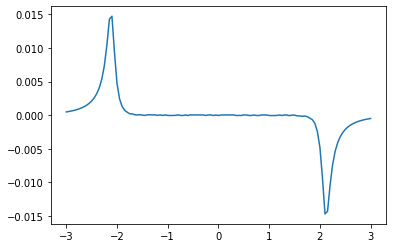

In [245]:
_=plt.plot(Weights,[w[2] for w in wtc_04])

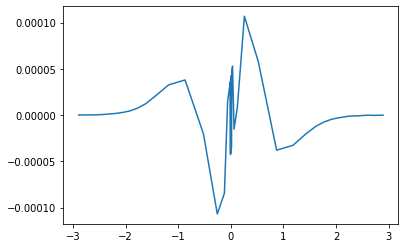

In [277]:
# plt.plot(Weights, [ w[2]+d2_tanh(w[1])/25. for w in wtc_04])
plt.plot([w[1] for w in wtc_04 ], 
        [w[2]+d2_tanh(w[1])*.04 for w in wtc_04] )

HUH??

trial 1/1 with 250 epochs, iter 0 of 211
trial 1/1 with 250 epochs, iter 100 of 211
trial 1/1 with 250 epochs, iter 200 of 211
done


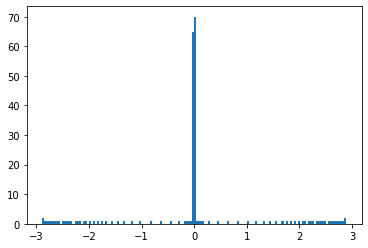

In [261]:
Weights, bounds = weights_range(-3,3,35)
wtc_05 =query_manual_model_wrapper(n_epochs=250, batchsize=1)
_=plt.hist([w[1] for w in wtc_05],150)

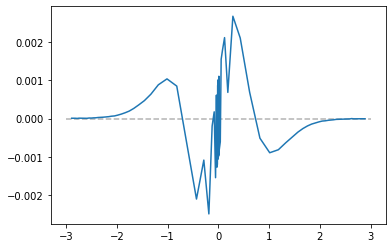

In [274]:
plot_range = bounds #[-2.5,2.5]
plt.plot(plot_range,[0,0], '--', color=[0,0,0,0.3])
plt.plot([w[1] for w in wtc_05 ], 
             [w[2]*25+d2_tanh(w[1]) for w in wtc_05 ] ,
        )    
# plt.plot([w[1] for w in wtc_05 if w[0]==trial_counter and plot_range[0]<w[1] and plot_range[1]>w[1]], 
#              [(w[2]+d2_tanh(w[1])*.04 - d4_tanh_new(w[1])*4e-4) for w in wtc_05 if plot_range[0]<w[1] and plot_range[1]>w[1]] ,
#         )


In [289]:
# plt.plot(Weights, 
#              [w[2]*25+d2_tanh(Weights[i]) for i,w in enumerate(wtc_05) ] ,
#         ) 
print(Weights[:6])
print([w[0] for w in wtc_05[:6]])
print([w[1] for w in wtc_05[:6]])
print([w[2] for w in wtc_05[:6]])


[-3.         -2.97142857 -2.94285714 -2.91428571 -2.88571429 -2.85714286]
[0, 0, 0, 0, 0, 0]
[-2.8913586, -2.855695, -2.8195188, -2.7827816, -2.7454343, -2.7074199]
[0.00048708916, 0.0005226135, 0.00056123734, 0.000603199, 0.0006494522, 0.00069975853]


In [306]:
# Weights, bounds = weights_range(-3,3,10)
# wtc_06, all_weights_06 =query_manual_model_wrapper(n_epochs=1, batchsize=1, return_raw_weights=True)
# _=plt.hist([w[1] for w in wtc_06],150)
# A = np.array(all_weights_06).squeeze()
# print(A.shape)
# print(A[:4,:4])

# print(Weights[:5])

(121, 121)
[[-3.   -2.95 -2.9  -2.85]
 [-3.   -2.95 -2.9  -2.85]
 [-3.   -2.95 -2.9  -2.85]
 [-3.   -2.95 -2.9  -2.85]]


(-3, 3)


Text(0.5, 1.0, "In this figure and following similar figures, each line represents an individual weight and its\ntrajectory as it learns. Red->green color corresponds to the initial weight's color (by way of its\nsequential order). These plots are analogous to the ones in stochastic-process-convergence-sanity-check.py .")

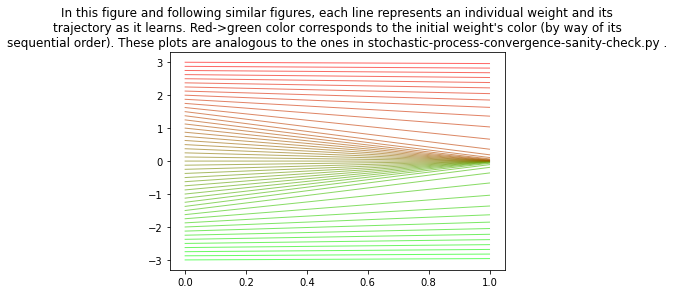

In [426]:
Weights, bounds = weights_range(-3,3,8)
print(bounds)
#wtc_06 =query_manual_model_wrapper(n_epochs=100, batchsize=1)
for i,w in enumerate(Weights):
#     plt.plot([0,1], [w,wtc_06[i][1]], color=[0,0,0,0.4], linewidth=1)
    plt.plot([0,1], [w,wtc_06[i][1]], color=[1.*(w-bounds[0])/(bounds[1]-bounds[0]),
                                             1.-(w-bounds[0])/(bounds[1]-bounds[0]),
                                             0,
                                             0.6], linewidth=1)
plt.title("In this figure and following similar figures, each line represents an individual weight and its\n"+\
    "trajectory as it learns. Red->green color corresponds to the initial weight's color (by way of its\n"+\
    "sequential order). These plots are analogous to the ones in stochastic-process-convergence-sanity-check.py.")
pass

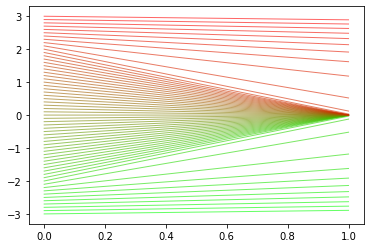

In [333]:
Weights, bounds = weights_range(-3,3,10)
# wtc_07 =query_manual_model_wrapper(n_epochs=250, batchsize=1)
for i,w in enumerate(Weights):
#     plt.plot([0,1], [w,wtc_07[i][1]], color=[0,0,0,0.4], linewidth=1)
    plt.plot([0,1], [w,wtc_07[i][1]], color=[1.*(w-bounds[0])/(bounds[1]-bounds[0]),
                                             1.-(w-bounds[0])/(bounds[1]-bounds[0]),
                                             0,
                                             0.6], linewidth=1)

Text(0.5, 0, 'first...last epoch')

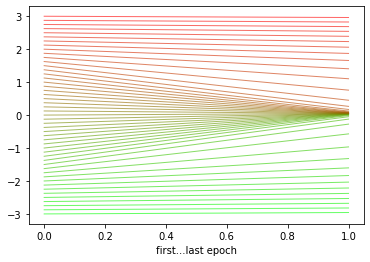

In [337]:
Y_data = [-1,1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
# wtc_08 =query_manual_model_wrapper(n_epochs=100, batchsize=1)
for i,w in enumerate(Weights):
    plt.plot([0,1], [w,wtc_08[i][1]], color=[1.*(w-bounds[0])/(bounds[1]-bounds[0]),
                                             1.-(w-bounds[0])/(bounds[1]-bounds[0]),
                                             0,
                                             0.6], linewidth=1)
plt.xlabel('first...last epoch')

trial 1/1 with 100 epochs, iter 0 of 49
trial 1/1 with 100 epochs, iter 4 of 49
trial 1/1 with 100 epochs, iter 8 of 49
trial 1/1 with 100 epochs, iter 12 of 49
trial 1/1 with 100 epochs, iter 16 of 49
trial 1/1 with 100 epochs, iter 20 of 49
trial 1/1 with 100 epochs, iter 24 of 49
trial 1/1 with 100 epochs, iter 28 of 49
trial 1/1 with 100 epochs, iter 32 of 49
trial 1/1 with 100 epochs, iter 36 of 49
trial 1/1 with 100 epochs, iter 40 of 49
trial 1/1 with 100 epochs, iter 44 of 49
trial 1/1 with 100 epochs, iter 48 of 49
done


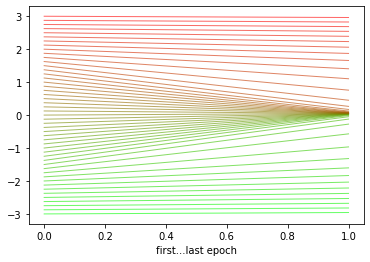

In [338]:
Weights, bounds = weights_range(-3,3,8)
Y_data = [-0.2,0.3]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
wtc_09 =query_manual_model_wrapper(n_epochs=100, batchsize=1)
plt.xlabel('first...last epoch')
for i,w in enumerate(Weights):
    plt.plot([0,1], [w,wtc_09[i][1]], color=[1.*(w-bounds[0])/(bounds[1]-bounds[0]),
                                             1.-(w-bounds[0])/(bounds[1]-bounds[0]),
                                             0,
                                             0.6], linewidth=1)

In [7]:
def query_manual_model_wrapper_2(n_epochs=1, batchsize=len(Y_data), return_raw_weights=True):

    weights_inbox = []
    changes_inbox = []
    weights_to_changes = []  # tuple of indices counter-coords then data (weight, change)
    all_raw_weights=[]
    
    model=init_manual_model(Nonlinearity)

    weights_retreiver = LambdaCallback( 
            on_epoch_begin=lambda batch, logs: weights_inbox.append( model.layers[0].get_weights()[0]))
    changes_retriever = LambdaCallback( 
            on_epoch_end  =lambda batch, logs: changes_inbox.append( model.layers[0].get_weights()[0]))        
    weights_storer = LambdaCallback( 
            on_epoch_begin=lambda batch, logs: all_raw_weights[-1].append( model.layers[0].get_weights()[0]))

    
    iter_count=0
    for trial_counter in range(N_trials):
        Set_weights(model.layers[0], Weights[0:1])
        initial_weights=[]
        for weight_counter in range(Weights.shape[0]):
            all_raw_weights.append([])
            Set_weights(model.layers[0], Weights[weight_counter:weight_counter+1])
            model.fit(
                np.array(X_data),  
                np.array(Y_data),
                batch_size=batchsize,
                epochs=n_epochs,
                callbacks=[weights_retreiver, changes_retriever, weights_storer], 
                verbose=0
            )
            change = changes_inbox[-1]-weights_inbox[-1]
            weights_to_changes.append( (trial_counter, weights_inbox[-1][0][0], change[0][0]) )

            epoch_str = ' with '+str(n_epochs)+' epochs' if n_epochs>1 else ''
            
            if (Weights.shape[0]*N_trials>100 and iter_count%100==0) \
                or (Weights.shape[0]*N_trials<=100 and weight_counter % min(25,int(Weights.shape[0]/10)) == 0):
                print('trial '+str(trial_counter+1)+'/'+str(N_trials)+epoch_str+', iter '+
                              str(weight_counter)+' of '+str(Weights.shape[0]))
            iter_count += 1 
#             if weight_counter % min(25,int(Weights.shape[0]/10)) == 0:
    print('done')
    if return_raw_weights:
        return weights_to_changes, all_raw_weights
    return weights_to_changes
    
#wtc=query_manual_model_wrapper()
print(wtc[:5])


NameError: name 'wtc' is not defined

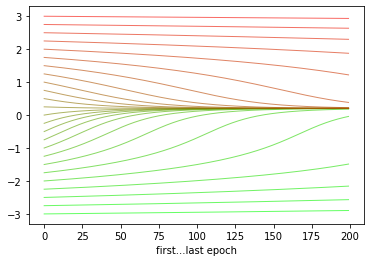

In [373]:
Weights, bounds = weights_range(-3,3,4)
Y_data = [0.1,0.3]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
#W__, all_weights =wtc_10=query_manual_model_wrapper_2(n_epochs=200, batchsize=1)
len(all_weights[0])

plt.xlabel('first...last epoch')
#print(all_weights[0])
for i,weight_lifecourse in enumerate(all_weights):
    N=len(all_weights)
    weight_lifecourse = [a[0][0] for a in weight_lifecourse]
    plt.plot(range(len(weight_lifecourse)), weight_lifecourse, 
                                      color=[1.*i/N,
                                             1.-i/N,
                                             0,
                                             0.6], linewidth=1)

trial 1/1 with 200 epochs, iter 0 of 25
trial 1/1 with 200 epochs, iter 2 of 25
trial 1/1 with 200 epochs, iter 4 of 25
trial 1/1 with 200 epochs, iter 6 of 25
trial 1/1 with 200 epochs, iter 8 of 25
trial 1/1 with 200 epochs, iter 10 of 25
trial 1/1 with 200 epochs, iter 12 of 25
trial 1/1 with 200 epochs, iter 14 of 25
trial 1/1 with 200 epochs, iter 16 of 25
trial 1/1 with 200 epochs, iter 18 of 25
trial 1/1 with 200 epochs, iter 20 of 25
trial 1/1 with 200 epochs, iter 22 of 25
trial 1/1 with 200 epochs, iter 24 of 25
done


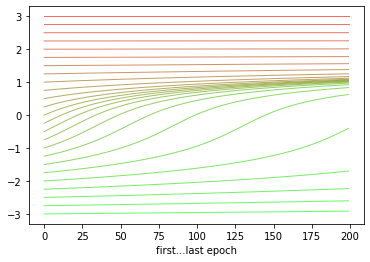

In [376]:
Weights, bounds = weights_range(-3,3,4)
Y_data = [1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
W__, all_weights =wtc_11=query_manual_model_wrapper_2(n_epochs=200, batchsize=1)
len(all_weights[0])

plt.xlabel('first...last epoch')
N=len(all_weights)
for i,weight_lifecourse in enumerate(all_weights):
    weight_lifecourse = [a[0][0] for a in weight_lifecourse]
    plt.plot(range(len(weight_lifecourse)), weight_lifecourse, 
                                      color=[1.*i/N,
                                             1.-i/N,
                                             0,
                                             0.6], linewidth=1)

trial 1/1 with 200 epochs, iter 0 of 25
trial 1/1 with 200 epochs, iter 2 of 25
trial 1/1 with 200 epochs, iter 4 of 25
trial 1/1 with 200 epochs, iter 6 of 25
trial 1/1 with 200 epochs, iter 8 of 25
trial 1/1 with 200 epochs, iter 10 of 25
trial 1/1 with 200 epochs, iter 12 of 25
trial 1/1 with 200 epochs, iter 14 of 25
trial 1/1 with 200 epochs, iter 16 of 25
trial 1/1 with 200 epochs, iter 18 of 25
trial 1/1 with 200 epochs, iter 20 of 25
trial 1/1 with 200 epochs, iter 22 of 25
trial 1/1 with 200 epochs, iter 24 of 25
done


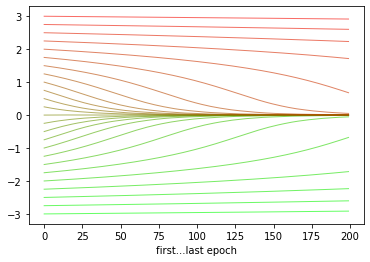

In [377]:
Weights, bounds = weights_range(-3,3,4)
Y_data = [-1,1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
W__, all_weights =wtc_12=query_manual_model_wrapper_2(n_epochs=200, batchsize=1)
len(all_weights[0])

plt.xlabel('first...last epoch')
N=len(all_weights)
for i,weight_lifecourse in enumerate(all_weights):
    weight_lifecourse = [a[0][0] for a in weight_lifecourse]
    plt.plot(range(len(weight_lifecourse)), weight_lifecourse, 
                                      color=[1.*i/N,
                                             1.-i/N,
                                             0,
                                             0.6], linewidth=1)

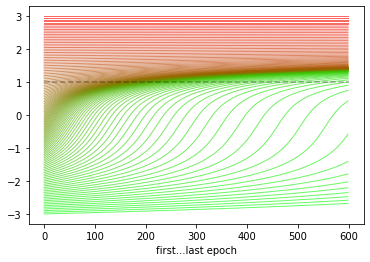

In [397]:
Weights, bounds = weights_range(-3,3,20)
Y_data = [1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
#W__, all_weights =wtc_13=query_manual_model_wrapper_2(n_epochs=600, batchsize=1)
len(all_weights[0])

plt.xlabel('first...last epoch')
N=len(all_weights)
for i,weight_lifecourse in enumerate(all_weights):
    weight_lifecourse = [a[0][0] for a in weight_lifecourse]
    plt.plot(range(len(weight_lifecourse)), weight_lifecourse, 
                                      color=[1.*i/N,
                                             1.-i/N,
                                             0,
                                             0.6], linewidth=1)
plt.plot([0,600],[Y_data[0],Y_data[0]], '--', color=[0,0,0,0.3])

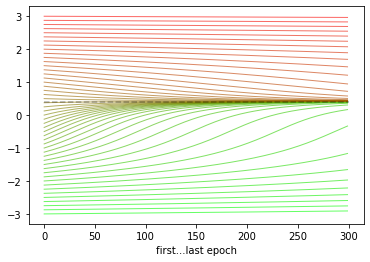

In [408]:
Weights, bounds = weights_range(-3,3,8)
Y_data = [0.4]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
#W__, all_weights =wtc_14=query_manual_model_wrapper_2(n_epochs=300, batchsize=1)
len(all_weights[0])

plt.xlabel('first...last epoch')
N=len(all_weights)
for i,weight_lifecourse in enumerate(wtc_14[1]):
    weight_lifecourse = [a[0][0] for a in weight_lifecourse]
    plt.plot(range(len(weight_lifecourse)), weight_lifecourse, 
                                      color=[1.*i/N,
                                             1.-i/N,
                                             0,
                                             0.6], linewidth=1)
plt.plot([0,300],[Y_data[0],Y_data[0]], '--', color=[0,0,0,0.3])

trial 1/1 with 200 epochs, iter 0 of 121
trial 1/1 with 200 epochs, iter 100 of 121
done


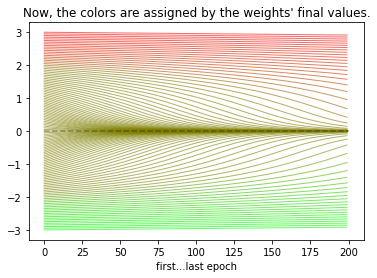

In [415]:
Weights, bounds = weights_range(-3,3,15)
Y_data = [-1,1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
W__, all_weights =wtc_15=query_manual_model_wrapper_2(n_epochs=200, batchsize=1)
len(all_weights[0])



plt.title("Now, the colors are assigned by the weights' final values.")
plt.xlabel('first...last epoch')
N=len(all_weights)
for i,weight_lifecourse in enumerate(all_weights):
    weight_lifecourse = [a[0][0] for a in weight_lifecourse]
    clr_float = (weight_lifecourse[-1]-bounds[0])/(bounds[1]-bounds[0])
    plt.plot(range(len(weight_lifecourse)), weight_lifecourse, 
                                      color=[clr_float,
                                             1.-clr_float,
                                             0,
                                             0.6], linewidth=1)
plt.plot([0,200],[0,0], '--', color=[0,0,0,0.3])

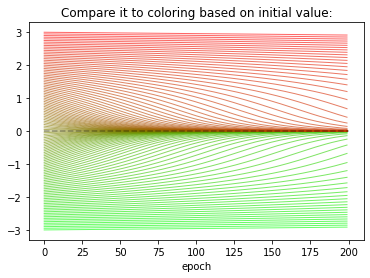

In [423]:
plt.title("Compare it to coloring based on initial value:")
plt.xlabel('epoch')
N=len(all_weights)
for i,weight_lifecourse in enumerate(all_weights):
    weight_lifecourse = [a[0][0] for a in weight_lifecourse]
    clr_float = (weight_lifecourse[0]-bounds[0])/(bounds[1]-bounds[0])
    plt.plot(range(len(weight_lifecourse)), weight_lifecourse, 
                                      color=[clr_float,
                                             1.-clr_float,
                                             0,
                                             0.6], linewidth=1)
plt.plot([0,200],[0,0], '--', color=[0,0,0,0.3])

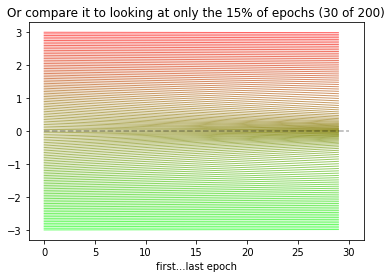

In [425]:
plt.title("Or compare it to looking at only the 15% of epochs (30 of 200)")
plt.xlabel('first...last epoch')
all_weights = wtc_15[1]
N=len(all_weights)
for i,weight_lifecourse in enumerate(all_weights):
    weight_lifecourse = [a[0][0] for a in weight_lifecourse][:30]
    clr_float = (weight_lifecourse[-1]-bounds[0])/(bounds[1]-bounds[0])
    plt.plot(range(len(weight_lifecourse)), weight_lifecourse, 
                                      color=[clr_float,
                                             1.-clr_float,
                                             0,
                                             0.6], linewidth=1)
plt.plot([0,30],[0,0], '--', color=[0,0,0,0.3])

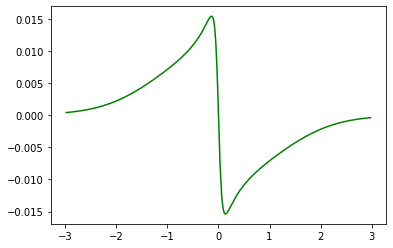

In [19]:
# you're gonna want to numpy-ify this before running it again

Weights, bounds = weights_range(-3,3,50)
Y_data = list(np.linspace(-1, 1, 8))
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
n_epochs, batchsize = 50, 4
N_trials=1

# wtc_triples, all_weights =wtc_16=query_manual_model_wrapper_2(n_epochs=n_epochs, batchsize=batchsize)

# N=len(all_weights)
# for i,weight_lifecourse in enumerate(all_weights):
#     weight_lifecourse = [a[0][0] for a in weight_lifecourse]
#     plt.plot(range(len(weight_lifecourse)), weight_lifecourse, 
#                                       color=[1.*i/N,
#                                              1.-i/N,
#                                              0,
#                                              0.6], linewidth=1)
# plt.plot([0,n_epochs],[Y_data[0],Y_data[0]], '--', color=[0,0,0,0.3])

# wtc16_3windowed = [ [(w16[i][0,0]+w16[i+1][0,0]+w16[i+2][0,0] )/3.      for i in range(len(w16)-2)]   for w16 in all_weights]
# print(wtc16_3windowed[0][:4])

# print(len(wtc_triples))

### [(wtc_16[0][2:][i]+wtc_16[0][1:-1][i]+wtc_16[0][-2:][i])/3. for i in range(len(wtc_16[0])-2) ]
# plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
# plt.plot([w[1] for w in wtc_16[0] ],[wtc16_3windowed[i]+d2_tanh(wtc_triples[i][1])/25. for i in range(len(wtc16_3windowed)) ] ,color='blue')   
# plt.plot([w[1] for w in wtc_16[0] ],[w[2] for w in wtc16_3windowed ] ,color='red')    
plt.plot([w[1] for w in wtc_16[0] ],[w[2]-w[1] for w in wtc16_3windowed ] ,color='green')    

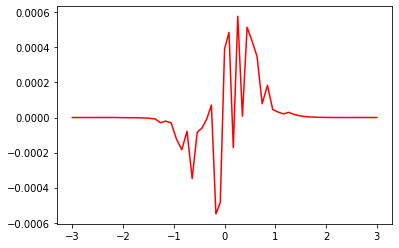

In [33]:
# you're gonna want to numpy-ify this before running it again

Weights, bounds = weights_range(-3,3,10)
Y_data = [-1,1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
n_epochs, batchsize = 5, 1
N_trials=1

# wtc_triples, all_weights =wtc_17_test=query_manual_model_wrapper_2(n_epochs=n_epochs, batchsize=batchsize)

# N=len(all_weights)
# for i,weight_lifecourse in enumerate(all_weights):
#     weight_lifecourse = [a[0][0] for a in weight_lifecourse]
#     plt.plot(range(len(weight_lifecourse)), weight_lifecourse, 
#                                       color=[1.*i/N,
#                                              1.-i/N,
#                                              0,
#                                              0.6], linewidth=1)
# plt.plot([0,n_epochs],[Y_data[0],Y_data[0]], '--', color=[0,0,0,0.3])

wtc17_3windowed = [ [(w17[i][0,0]+w17[i+1][0,0]+w17[i+2][0,0] )/3.      for i in range(len(w17)-2)]   for w17 in all_weights]
# print(wtc16_3windowed[0][:4])

# print(len(wtc_triples))

### [(wtc_16[0][2:][i]+wtc_16[0][1:-1][i]+wtc_16[0][-2:][i])/3. for i in range(len(wtc_16[0])-2) ]
# plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
# plt.plot([w[1] for w in wtc_16[0] ],[wtc16_3windowed[i]+d2_tanh(wtc_triples[i][1])/25. for i in range(len(wtc16_3windowed)) ] ,color='blue')   
plt.plot([w[1] for w in wtc_triples ],[w[2]+d2_tanh(w[1])/25. for w in wtc_triples ] ,color='red')    
# plt.plot([w[1] for w in wtc_triples ],[w[2]-w[1] for w in wtc17_3windowed ] ,color='green')    

In [ ]:
len(wtc_triples[1])

In [445]:
len(all_weights[0])

50

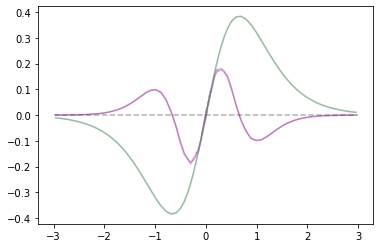

In [29]:
# Question: what are the actual numbers? How different is d2 from d4 in order of magnitude?
Y_data = [-.01,.01]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,30)
N_trials = 1
normz=True
# learning_rate = 0.01
#wtc=wtc100=query_manual_model_wrapper(n_epochs=100, batchsize=1)

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [( 0.25*(w[2] - -25**-1*(d2_tanh(w[1])) if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[.5, 0, .5, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d4_tanh_new(w[1]) for w in wtc if w[0]==trial_counter],
                 color=[.5, 0, .5, 0.3])  
    # ^ Multiplicative factors: 1/4, -1/25
    
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [-25*w[2] for w in wtc if w[0]==trial_counter],
                 color=[.5, .5, 0, 0.3])  
    # ^ Multiplicative factor: -25
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d2_tanh(w[1]) for w in wtc if w[0]==trial_counter],
                 color=[0, .5, .5, 0.3])          

trial 1/1 with 100 epochs, iter 0 of 181
trial 1/1 with 100 epochs, iter 100 of 181
done


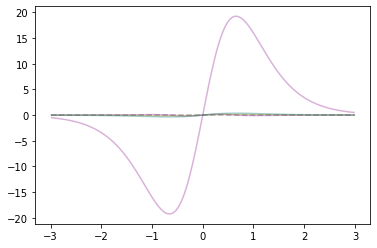

In [31]:
# Question: what are the actual numbers? How different is d2 from d4 in order of magnitude?
Y_data = [-.01,.01]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,30)
N_trials = 1
normz=True
learning_rate = 0.005
wtc100_half_lr=query_manual_model_wrapper(n_epochs=100, batchsize=1, learning_rate=learning_rate)
wtc=wtc100_half_lr

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [( 0.25*(w[2] - -25**-1*(d2_tanh(w[1])) if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[.5, 0, .5, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d4_tanh_new(w[1]) for w in wtc if w[0]==trial_counter],
                 color=[.5, 0, .5, 0.3])  
    # ^ Multiplicative factors: 1/4, -1/25
    
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [-25*w[2] for w in wtc if w[0]==trial_counter],
                 color=[.5, .5, 0, 0.3])  
    # ^ Multiplicative factor: -25
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d2_tanh(w[1]) for w in wtc if w[0]==trial_counter],
                 color=[0, .5, .5, 0.3]) 

^ Result: changing learning rate drastically affects d2 and d4. Does it change it by 1/2 though?

trial 1/1 with 100 epochs, iter 0 of 181
trial 1/1 with 100 epochs, iter 100 of 181
done


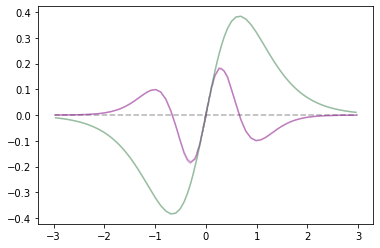

In [32]:
# Question: what are the actual numbers? How different is d2 from d4 in order of magnitude?
Y_data = [-.005,.005]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,30)
N_trials = 1
normz=True
learning_rate = 0.01
wtc100_half_y_range=query_manual_model_wrapper(n_epochs=100, batchsize=1, learning_rate=learning_rate)
wtc=wtc100_half_y_range

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [( 0.25*(w[2] - -25**-1*(d2_tanh(w[1])) if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[.5, 0, .5, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d4_tanh_new(w[1]) for w in wtc if w[0]==trial_counter],
                 color=[.5, 0, .5, 0.3])  
    # ^ Multiplicative factors: 1/4, -1/25
    
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [-25*w[2] for w in wtc if w[0]==trial_counter],
                 color=[.5, .5, 0, 0.3])  
    # ^ Multiplicative factor: -25
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d2_tanh(w[1]) for w in wtc if w[0]==trial_counter],
                 color=[0, .5, .5, 0.3]) 

^ Result: changing y range variation does not change d2 and d4. -> So this should work with all kinds of y such as [1,-1] and [1e-6, -1e-6] !?

trial 1/1 with 50 epochs, iter 0 of 181
trial 1/1 with 50 epochs, iter 100 of 181
done


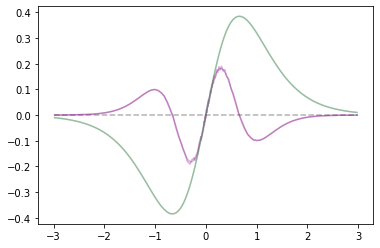

In [33]:
# Question: what are the actual numbers? How different is d2 from d4 in order of magnitude?
Y_data = [-.01,.01]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,30)
N_trials = 1
normz=True
learning_rate = 0.01
wtc100_half_epochs=query_manual_model_wrapper(n_epochs=50, batchsize=1, learning_rate=learning_rate)
wtc=wtc100_half_epochs

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [( 0.25*(w[2] - -25**-1*(d2_tanh(w[1])) if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[.5, 0, .5, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d4_tanh_new(w[1]) for w in wtc if w[0]==trial_counter],
                 color=[.5, 0, .5, 0.3])  
    # ^ Multiplicative factors: 1/4, -1/25
    
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [-25*w[2] for w in wtc if w[0]==trial_counter],
                 color=[.5, .5, 0, 0.3])  
    # ^ Multiplicative factor: -25
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d2_tanh(w[1]) for w in wtc if w[0]==trial_counter],
                 color=[0, .5, .5, 0.3]) 

^ Result: changing number of batches does not change d2 and d4. -> So this should work with all kinds of number of batches

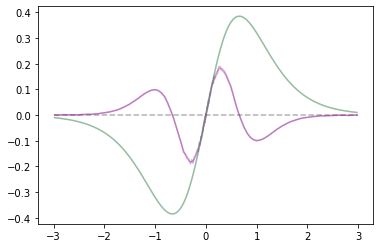

In [67]:
wtc=wtc100_half_lr

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [( w[2] + 0.02*(d2_tanh(w[1]) if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[.5, 0, .5, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d4_tanh_new(w[1]) for w in wtc if w[0]==trial_counter],
                 color=[.5, 0, .5, 0.3])  
    # ^ Multiplicative factors: 1, -1/50
    
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [-50*w[2] for w in wtc if w[0]==trial_counter],
                 color=[.5, .5, 0, 0.3])  
    # ^ Multiplicative factor: -50
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d2_tanh(w[1]) for w in wtc if w[0]==trial_counter],
                 color=[0, .5, .5, 0.3]) 

Results
Interestingly, among the three varied conditions of number of epochs for training, spread of initial y values, and value of learning rate, the only factor that affected relative differences of D2 and D4 were learning rate. Specifically, with 2x the learning rate, D2 was 2x larger both empirically and theoretically, and D4 was the same theoretically. Empirically it's interesting: D4 was 4x larger, but specifically, the noise signal that is isolated (the D4 empirical) is **twice** as powerful. (ie, while D2 had to be 4x larger, the change of weights observable was only 2x larger to match the changed signal.) --> does this just mean the D4 component was unchanged though...

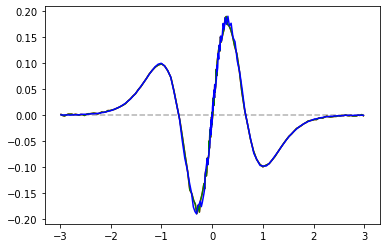

In [85]:
for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    wtc=wtc100_half_lr
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [( w[2] + 0.02*(d2_tanh(w[1]) if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color='red')
    wtc100_half_y_range
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [( w[2] + 0.02*(d2_tanh(w[1]) if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color='green')    
    wtc=wtc100_half_epochs
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [( 0.25*w[2] + 0.01*(d2_tanh(w[1]) if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color='blue')

In [186]:
# empty space for development convenience


























